In [1]:
import numpy as np
import math, random, time, os
import matplotlib.pyplot as plt
from matplotlib.patches import Circle, Rectangle
from tqdm.auto import tqdm
import numba

seed = 40 
rng = np.random.default_rng(seed)
random.seed(seed)

domain_width  = 200.0  # [um]
domain_height = 200.0  # [um]

# ── CAM1, CAM2, SE
D1, D2, D3 = 4.0, 4.0, 1.0
f1, f2, f3 = 0.56, 0.24, 0.2
phi_s      = 0.45  

gravity          = 9.81e-4 
dt               = 0.2      
substeps         = 4        
collision_iters  = 60
friction_mu      = 0.05
restitution      = 0.02
velocity_damping = 1.0    
penetration_tol   = 1e-6    
vel_tol           = 3e-6    
min_outer_steps   = 1000    
patience          = 25     
max_iter      = 10000
show_progress = True  
save_frames = True         
save_every  = 50            
frames_dir  = "dem_frames_v1"  
colors = {"CAM1":"royalblue", "CAM2":"royalblue", "CAM3":"lightgreen"}
SHOW_AXES   = True
TICK_STEP_X = 10.0
TICK_STEP_Y = 10.0
SHOW_GRID   = False  

# === Papermill child-run guard  ===
_PM_CHILD_RUN = False

import os, time
from typing import Iterable
try:
    from tqdm.auto import tqdm as _tqdm
except Exception:
    _tqdm = None

IS_BATCH_CHILD = bool(globals().get("_PM_CHILD_RUN", False))
TQDM_MINSEC = float(os.getenv("TQDM_MININTERVAL", "5"))   
TQDM_MINPCT = float(os.getenv("TQDM_MINPCT", "1"))        

def progress_iter(total: int, desc: str = "") -> Iterable[int]:
    if not IS_BATCH_CHILD and _tqdm is not None:
        miniters = max(1, int(total * (TQDM_MINPCT / 100.0)))
        yield from _tqdm(range(total), desc=desc, mininterval=TQDM_MINSEC,
                         miniters=miniters, dynamic_ncols=True, leave=False)
        return
    step_pct = max(1, int(total * (TQDM_MINPCT / 100.0)))  # 1% 간격
    last_t = time.time()
    for i in range(total):
        if (i % step_pct == 0) or (time.time() - last_t >= TQDM_MINSEC):
            pct = (i / total) * 100.0
            print(f"{desc}: {i}/{total} ({pct:4.1f}%)", flush=True)
            last_t = time.time()
        yield i
    print(f"{desc}: {total}/{total} (100.0%)", flush=True)

In [3]:
def draw_domain_box(ax, W, H, color='white', lw=1.5, z=1000):
    ax.add_patch(Rectangle((0, 0), W, H, fill=False,
                           edgecolor=color, linewidth=lw, zorder=z))

def set_axes(ax, W, H, show_axes=True, step_x=10.0, step_y=10.0, grid=False, color='w'):
    ax.set_xlim(0, W); ax.set_ylim(0, H)
    ax.set_aspect('equal', adjustable='box')

    if not show_axes:
        ax.axis('off')
        return

    if step_x and step_x > 0:
        ax.set_xticks(np.arange(0, W + 1e-9, step_x))
    if step_y and step_y > 0:
        ax.set_yticks(np.arange(0, H + 1e-9, step_y))

    ax.tick_params(axis='both', colors=color, labelsize=9, direction='out', length=3, width=0.8)
    for spine in ax.spines.values():
        spine.set_color(color)
        spine.set_linewidth(1.0)

    if grid:
        ax.grid(True, linestyle='--', alpha=0.25, color=color)

def area_of_disk(d):
    return math.pi*(0.5*d)**2

def compute_counts_from_phi(diams, fracs, phi_s, W, H):
    f = np.array(fracs, dtype=float)
    if f.sum() <= 0:
        raise ValueError("fraction=0.")
    f = f / f.sum()

    A_domain = W * H
    A_star   = phi_s * A_domain               
    a        = np.array([area_of_disk(d) for d in diams], dtype=float)

    N = np.floor(f * A_star / a + 0.5).astype(int)

 
    A_now = float(np.dot(N, a))
    idx   = int(np.argmax(f))
    delta = (A_star - A_now) / a[idx]
    N[idx] = max(0, int(round(N[idx] + delta)))
    return N

def build_grid(positions, cell):
    grid = {}
    for i, p in enumerate(positions):
        cx = int(p[0] // cell); cy = int(p[1] // cell)
        grid.setdefault((cx, cy), []).append(i)
    return grid

def place_random_nonoverlap(Ns, diams, W, H, tries_per_particle=2000):
    radii, types = [], []
    for t, (N, d) in enumerate(zip(Ns, diams), start=1):
        radii += [0.5*d]*N
        types += [t]*N
    radii = np.array(radii, dtype=float)
    types = np.array(types, dtype=np.int32)

    order = np.argsort(-radii)        
    radii = radii[order]
    types = types[order]

    P   = len(radii)
    pos = np.zeros((P, 2), dtype=float)
    cell = 2.0 * radii.max()
    grid = {}

    def can_place(i, xy):
        ri = radii[i]
        if not (ri <= xy[0] <= W - ri and ri <= xy[1] <= H - ri):
            return False
        cx = int(xy[0] // cell); cy = int(xy[1] // cell)
        for dx in (-1,0,1):
            for dy in (-1,0,1):
                for j in grid.get((cx+dx, cy+dy), []):
                    dx_ = xy[0] - pos[j,0]; dy_ = xy[1] - pos[j,1]
                    if dx_*dx_ + dy_*dy_ < (radii[i] + radii[j])**2:
                        return False
        return True

    for i in range(P):
        placed = False
        for _ in range(tries_per_particle):
            xy = np.array([rng.uniform(radii[i], W - radii[i]),
                           rng.uniform(radii[i], H - radii[i])], dtype=float)
            if can_place(i, xy):
                pos[i] = xy
                cx = int(xy[0] // cell); cy = int(xy[1] // cell)
                grid.setdefault((cx, cy), []).append(i)
                placed = True
                break
        if not placed:
            raise RuntimeError(
                f"initial failed (i={i}, r={radii[i]:.3f}). "
                f"lower phi_s or increase domain size."
            )

    inv = np.empty(P, dtype=int); inv[order] = np.arange(P)
    return pos[inv], radii[inv], types[inv]

In [4]:
import numba, math

@numba.njit(fastmath=True)
def project_pairs_numba(p, v, r, m, pairs, restitution, mu):
    M = pairs.shape[0]
    for k in range(M):
        i = pairs[k, 0]
        j = pairs[k, 1]
        dx0 = p[j,0] - p[i,0]
        dx1 = p[j,1] - p[i,1]
        R   = r[i] + r[j]
        d2  = dx0*dx0 + dx1*dx1
        if d2 >= R*R or d2 == 0.0:
            continue


        d  = math.sqrt(d2)
        nx = dx0 / d; ny = dx1 / d                   
        tx = -ny;  ty = nx                         
        ov = R - d
        w1 = m[j] / (m[i] + m[j])
        w2 = 1.0 - w1
        p[i,0] -= w1 * ov * nx; p[i,1] -= w1 * ov * ny
        p[j,0] += w2 * ov * nx; p[j,1] += w2 * ov * ny
        dvx = v[j,0] - v[i,0]
        dvy = v[j,1] - v[i,1]
        vn  = dvx*nx + dvy*ny                        
        vt  = dvx*tx + dvy*ty                        
        meff = (m[i] * m[j]) / (m[i] + m[j])

        if vn < 0.0:
            Jn = -(1.0 + restitution) * vn * meff   
            v[i,0] -= (Jn / m[i]) * nx; v[i,1] -= (Jn / m[i]) * ny
            v[j,0] += (Jn / m[j]) * nx; v[j,1] += (Jn / m[j]) * ny
        else:
            Jn = 0.0

        if vt != 0.0:
            Jt_ideal = - vt * meff                   
            Jt_max   = mu * abs(Jn)                 
            if Jt_ideal >  Jt_max: Jt =  Jt_max
            elif Jt_ideal < -Jt_max: Jt = -Jt_max
            else: Jt = Jt_ideal
            v[i,0] -= (Jt / m[i]) * tx; v[i,1] -= (Jt / m[i]) * ty
            v[j,0] += (Jt / m[j]) * tx; v[j,1] += (Jt / m[j]) * ty

@numba.njit(fastmath=True)
def project_walls_numba(p, v, r, W, H, restitution):
    N = p.shape[0]
    for i in range(N):
        if p[i,0] < r[i]:
            ov = r[i] - p[i,0]
            p[i,0] += ov
            if v[i,0] < 0.0: v[i,0] = -restitution * v[i,0]
        if p[i,0] > W - r[i]:
            ov = p[i,0] - (W - r[i])
            p[i,0] -= ov
            if v[i,0] > 0.0: v[i,0] = -restitution * v[i,0]
        if p[i,1] < r[i]:
            ov = r[i] - p[i,1]
            p[i,1] += ov
            if v[i,1] < 0.0: v[i,1] = -restitution * v[i,1]
            v[i,0] *= 0.9  
        if p[i,1] > H - r[i]:
            ov = p[i,1] - (H - r[i])
            p[i,1] -= ov
            if v[i,1] > 0.0: v[i,1] = -restitution * v[i,1]

def _make_pairs(p, cell):
    grid = {}
    P = p.shape[0]
    for i in range(P):
        cx = int(p[i,0]//cell); cy = int(p[i,1]//cell)
        grid.setdefault((cx,cy), []).append(i)
    pairs = []
    for i in range(P):
        cx = int(p[i,0]//cell); cy = int(p[i,1]//cell)
        for dx in (-1,0,1):
            for dy in (-1,0,1):
                for j in grid.get((cx+dx, cy+dy), []):
                    if j > i:
                        pairs.append((i, j))
    if len(pairs) > 1:
        pairs = np.unique(np.asarray(pairs, dtype=np.int32), axis=0)
    else:
        pairs = np.asarray(pairs, dtype=np.int32)
    return pairs

def _make_pairs_with_skin(p, r, cell, skin):
    grid = {}
    P = p.shape[0]
    for i in range(P):
        cx = int(p[i,0]//cell); cy = int(p[i,1]//cell)
        grid.setdefault((cx,cy), []).append(i)
    pairs = []
    for i in range(P):
        cx = int(p[i,0]//cell); cy = int(p[i,1]//cell)
        for dx in (-1,0,1):
            for dy in (-1,0,1):
                for j in grid.get((cx+dx, cy+dy), []):
                    if j <= i: 
                        continue
                    R_skin = (r[i] + r[j] + skin)
                    dx0 = p[j,0]-p[i,0]; dx1 = p[j,1]-p[i,1]
                    if dx0*dx0 + dx1*dx1 <= R_skin*R_skin:
                        pairs.append((i,j))
    if len(pairs) > 1:
        pairs = np.unique(np.asarray(pairs, dtype=np.int32), axis=0)
    else:
        pairs = np.asarray(pairs, dtype=np.int32)
    return pairs

class NeighborList:
    def __init__(self, skin, cell):
        self.skin = float(skin)
        self.cell = float(cell)
        self.p_ref = None
        self.pairs = None

    def need_rebuild(self, p):
        if self.p_ref is None:
            return True
        dp = p - self.p_ref
        max_disp2 = float(np.max(dp[:,0]*dp[:,0] + dp[:,1]*dp[:,1]))
        return max_disp2 > (0.5*self.skin)*(0.5*self.skin)

    def rebuild(self, p, r):
        self.p_ref = p.copy()
        self.pairs = _make_pairs_with_skin(p, r, self.cell, self.skin)

def dem_settle(pos, rad, typ, rho, g, dt, substeps, iters,
               mu, restitution, vel_damp, W, H,
               max_iter=20000, pen_tol=1e-6, vel_tol=1e-5,
               min_outer_steps=200, patience=10,
               save_frames=False, save_every=200, frames_dir="dem_frames",
               colors=None, show_progress=True,
               pbar_update_every=50,     
               pbar_mininterval=0.25,    
               disp_tol=2e-4             
               ):

    N = len(rad)
    m = np.array([rho[t-1]*math.pi*rad[i]**2 for i,t in enumerate(typ)], dtype=np.float64)
    v = np.zeros((N,2), dtype=np.float64)
    p = np.ascontiguousarray(pos.copy(), dtype=np.float64)
    r = np.ascontiguousarray(rad.copy(), dtype=np.float64)

    if save_frames:
        os.makedirs(frames_dir, exist_ok=True)

    rmax = float(r.max()) if N > 0 else 0.0
    skin = max(0.3*rmax, 0.5)                
    cell = 2.0*rmax + skin                   
    nlist = NeighborList(skin=skin, cell=cell)

    start = time.time()
    pbar  = tqdm(total=max_iter, desc="DEM settle", unit="step", leave=True,
                 mininterval=pbar_mininterval, disable=not show_progress)
    stable = 0

    last_shown_it = 0
    last_pf_time  = time.time()

    try:
        for it in range(max_iter):
            for _ in range(substeps):
                v[:,1] -= g * (dt/substeps)
                v *= vel_damp
                p += v * (dt/substeps)

                if nlist.need_rebuild(p):
                    nlist.rebuild(p, r)
                pairs = nlist.pairs

                for _ in range(iters):
                    project_walls_numba(p, v, r, W, H, restitution)
                    if pairs is not None and pairs.shape[0] > 0:
                        project_pairs_numba(p, v, r, m, pairs, restitution, mu)

            pairs_chk = nlist.pairs if nlist.pairs is not None else _make_pairs(p, cell)
            max_ov = 0.0
            for ij in pairs_chk:
                i, j = int(ij[0]), int(ij[1])
                dx0 = p[j,0]-p[i,0]; dx1 = p[j,1]-p[i,1]
                R   = r[i]+r[j]
                d2  = dx0*dx0 + dx1*dx1
                if d2 < R*R:
                    ov = R - math.sqrt(d2)
                    if ov > max_ov: max_ov = ov

            v_inf = 0.0 if N==0 else float(np.max(np.abs(v)))
            disp_ok = (v_inf * dt) <= disp_tol
            converged_now = (max_ov <= pen_tol) and ( (v_inf <= vel_tol) or disp_ok )

            if it >= min_outer_steps and converged_now:
                stable += 1
            else:
                stable = 0

            if show_progress:
                if (it - last_shown_it) >= pbar_update_every or it == (max_iter - 1):
                    pbar.update(it - last_shown_it)
                    last_shown_it = it
                now = time.time()
                if (now - last_pf_time) >= pbar_mininterval:
                    pbar.set_postfix_str(f"ov={max_ov:.2e}, v_inf={v_inf:.2e}, stable={stable}/{patience}")
                    last_pf_time = now

            if save_frames and (it % save_every == 0):
                fig = plt.figure(figsize=(6, 6*H/W)); ax = plt.gca()
                ax.set_facecolor('#222')
                for k in range(N):
                    c = colors["CAM1"] if typ[k]==1 else colors["CAM2"] if typ[k]==2 else colors["CAM3"]
                    ax.add_patch(Circle((p[k,0], p[k,1]), r[k], facecolor=c, edgecolor='none'))
                draw_domain_box(ax, W, H, color='white', lw=1.0)
                set_axes(ax, W, H, show_axes=SHOW_AXES, step_x=TICK_STEP_X, step_y=TICK_STEP_Y, grid=SHOW_GRID)
                plt.title(f"DEM frame (it={it})", color='w')
                plt.tight_layout()
                plt.savefig(os.path.join(frames_dir, f"frame_{it//save_every:04d}.png"),
                            dpi=140, bbox_inches='tight', pad_inches=0); plt.close()

            if stable >= patience:
                if show_progress:
                    pbar.set_postfix_str(f"converged: ov={max_ov:.2e}, v_inf={v_inf:.2e}")
                print(f"[DONE] it={it}, max_overlap={max_ov:.3e}, v_inf={v_inf:.3e}, "
                      f"elapsed={time.time()-start:.2f}s")
                break

    finally:
        if show_progress:
            pbar.close()

    return p, v

N1,N2,N3 = [573, 573, 4584] (합=5730)
초기 배치 완료.

=== 초기 배치 통계 (DEM 전) ===
도메인 대비 솔리드 점유율  φ_s = 45.003% (목표 45.000%)
솔리드 내부 면적 분율 (합=100%):
  - CAM1: 40.00% (목표 40.00%)
  - CAM2: 40.00% (목표 40.00%)
  - SE  : 20.00% (목표 20.00%)


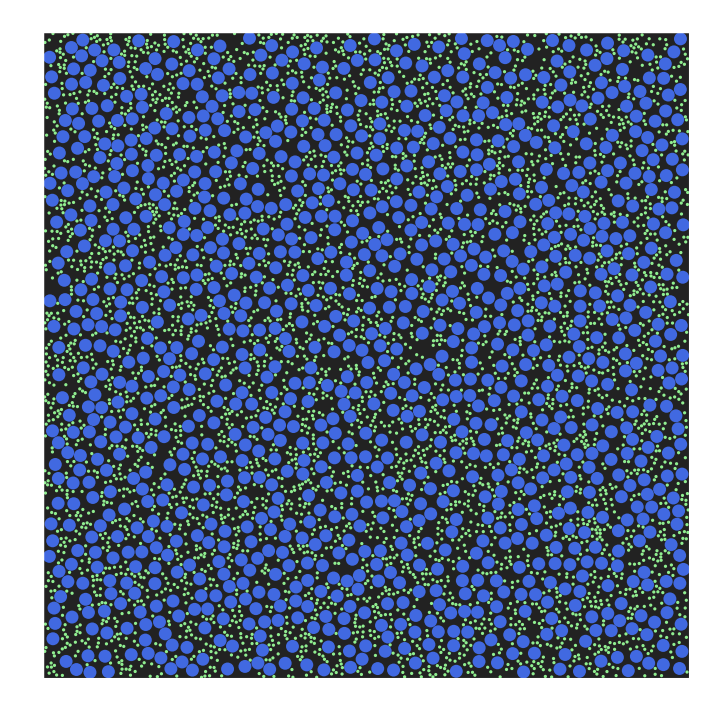

In [5]:
from matplotlib.patches import Circle
import numpy as np
import matplotlib.pyplot as plt

diams = [D1, D2, D3]
fracs = [f1, f2, f3]
Ns    = compute_counts_from_phi(diams, fracs, phi_s, domain_width, domain_height)
print(f"N1,N2,N3 = {Ns.tolist()} (SUM={Ns.sum()})")

pos_init, rad, typ = place_random_nonoverlap(Ns, diams, domain_width, domain_height)
print("initial geometry complete")

pos = pos_init.copy()

A_parts = np.pi * rad**2
A_sol   = float(A_parts.sum())
A_dom   = domain_width * domain_height

A1 = float(A_parts[typ == 1].sum())
A2 = float(A_parts[typ == 2].sum())
A3 = float(A_parts[typ == 3].sum())

phi_s_eff = A_sol / A_dom
f1_hat = A1 / A_sol if A_sol > 0 else 0.0
f2_hat = A2 / A_sol if A_sol > 0 else 0.0
f3_hat = A3 / A_sol if A_sol > 0 else 0.0

print("\n=== before DEM ===")
print(f"φ_s = {phi_s_eff:.3%} (Target {phi_s:.3%})")
print("Solid area fraction (SUM=100%):")
print(f"  - CAM1: {f1_hat*100:.2f}% (Target {f1*100:.2f}%)")
print(f"  - CAM2: {f2_hat*100:.2f}% (Target {f2*100:.2f}%)")
print(f"  - SE  : {f3_hat*100:.2f}% (Target {f3*100:.2f}%)")

fig = plt.figure(figsize=(7, 7*domain_height/domain_width), constrained_layout=True)
ax  = fig.add_subplot(111)
ax.set_facecolor('#222')
for i in range(len(rad)):
    c = colors["CAM1"] if typ[i]==1 else colors["CAM2"] if typ[i]==2 else colors["CAM3"]
    ax.add_patch(Circle((pos[i,0], pos[i,1]), rad[i], facecolor=c, edgecolor='none'))
draw_domain_box(ax, domain_width, domain_height, color='white', lw=1.5)
set_axes(ax, domain_width, domain_height,
         show_axes=SHOW_AXES, step_x=TICK_STEP_X, step_y=TICK_STEP_Y, grid=SHOW_GRID)
plt.title("Initial placement (no overlaps)", color='w')
plt.show()


=== 최종 통계 (DEM 후) ===
도메인 대비 솔리드 점유율  φ_s = 45.003% (목표 45.000%)
솔리드 내부 면적 분율 (합=100%):
  - CAM1: 40.00% (목표 40.00%)
  - CAM2: 40.00% (목표 40.00%)
  - SE  : 20.00% (목표 20.00%)


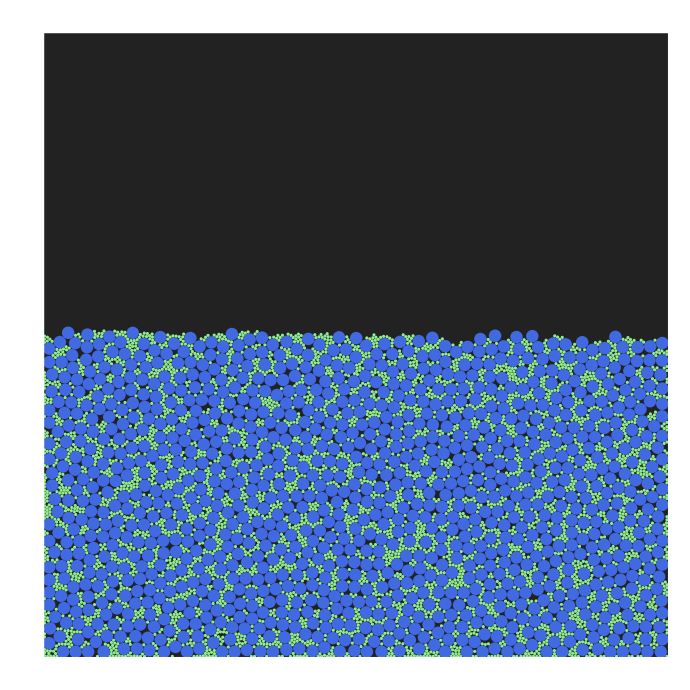

[anchor] LAST_DEM_HASH = 8ca5dcc71324…


In [6]:
import hashlib
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle

if globals().get("_PM_CHILD_RUN", False):
    import os, time
    import tqdm as _tqdm_mod
    import tqdm.auto as _tqdm_auto_mod

    _MINPCT = float(globals().get("TQDM_MINPCT", os.environ.get("TQDM_MINPCT", 1.0)))   
    _MINSEC = float(globals().get("TQDM_MININTERVAL", os.environ.get("TQDM_MININTERVAL", 5.0)))  

    class _ThinTQDM:
        def __init__(self, iterable=None, total=None, desc=None, **kw):
            self.iterable = iterable if iterable is not None else range(int(total or 0))
            self.total = int(total) if total is not None else (len(self.iterable) if hasattr(self.iterable, "__len__") else None)
            self.desc = desc or ""
            self.minpct = _MINPCT
            self.minsec = _MINSEC
            self.count = 0
            self._next_pct = self.minpct
            self._last_t = time.time()

        def __iter__(self):
            for x in self.iterable:
                self.count += 1
                now = time.time()
                if self.total:
                    pct = 100.0 * self.count / self.total
                    if (pct >= self._next_pct) and (now - self._last_t >= self.minsec):
                        print(f"{self.desc}: {self.count}/{self.total} ({pct:.1f}%)", flush=True)
                        self._next_pct += self.minpct
                        self._last_t = now
                else:
                    if (now - self._last_t >= self.minsec):
                        print(f"{self.desc}: {self.count}", flush=True)
                        self._last_t = now
                yield x

        def update(self, n=1): pass
        def set_postfix(self, *a, **k): pass
        def close(self): pass

    _tqdm_auto_mod.tqdm = _ThinTQDM
    _tqdm_mod.tqdm = _ThinTQDM

rho = [4.0, 4.0, 2.0]

if 'pos' not in globals():
    if 'pos1' in globals():
        print("[note] no 'pos', using 'pos1'.")
        pos = np.array(pos1, copy=True)
    else:
        raise RuntimeError("no Initial positions 'pos'. run Cell 4 first.")

pos, vel = dem_settle(
    pos, rad, typ, rho,
    gravity, dt, substeps, collision_iters,
    friction_mu, restitution, velocity_damping,
    domain_width, domain_height,
    max_iter=max_iter, pen_tol=penetration_tol, vel_tol=vel_tol,
    min_outer_steps=min_outer_steps, patience=patience,
    save_frames=save_frames, save_every=save_every,
    frames_dir=frames_dir, colors=colors,
    show_progress=not globals().get("_PM_CHILD_RUN", False)
)

A_parts_f = np.pi * rad**2
A_sol_f   = float(A_parts_f.sum())
A_dom     = domain_width * domain_height
phi_s_eff_f = A_sol_f / A_dom

A1_f = float(A_parts_f[typ == 1].sum())
A2_f = float(A_parts_f[typ == 2].sum())
A3_f = float(A_parts_f[typ == 3].sum())
f1_hat_f = A1_f / A_sol_f if A_sol_f > 0 else 0.0
f2_hat_f = A2_f / A_sol_f if A_sol_f > 0 else 0.0
f3_hat_f = A3_f / A_sol_f if A_sol_f > 0 else 0.0

print("\n=== after DEM ===")
print(f"φ_s = {phi_s_eff_f:.3%} (목표 {phi_s:.3%})")
print("SUM of area fraction (SUM=100%):")
print(f"  - CAM1: {f1_hat_f*100:.2f}% (목표 {f1*100:.2f}%)")
print(f"  - CAM2: {f2_hat_f*100:.2f}% (목표 {f2*100:.2f}%)")
print(f"  - SE  : {f3_hat_f*100:.2f}% (목표 {f3*100:.2f}%)")

fig = plt.figure(figsize=(7, 7*domain_height/domain_width))
ax  = plt.gca()
ax.set_facecolor('#222')

for i in range(len(rad)):
    c = colors["CAM1"] if typ[i]==1 else colors["CAM2"] if typ[i]==2 else colors["CAM3"]
    ax.add_patch(Circle((pos[i,0], pos[i,1]), rad[i], facecolor=c, edgecolor=None))

draw_domain_box(ax, domain_width, domain_height, color='white', lw=1.5)
set_axes(ax, domain_width, domain_height,
         show_axes=SHOW_AXES, step_x=TICK_STEP_X, step_y=TICK_STEP_Y, grid=SHOW_GRID)

plt.title("Final packing after gravity DEM (no overlaps)", color='w')
plt.tight_layout()
plt.show()

def _hash_state(W, H, POS, RAD, TYP):
    arrs = [
        np.array([float(W), float(H)], dtype=np.float64),
        np.asarray(POS, dtype=np.float64).ravel(),
        np.asarray(RAD, dtype=np.float64).ravel(),
        np.asarray(TYP, dtype=np.int64).ravel(),
    ]
    h = hashlib.sha1()
    for a in arrs:
        h.update(a.tobytes())
        h.update(str(a.shape).encode())
        h.update(str(a.dtype).encode())
    return h.hexdigest()

LAST_DEM_HASH = _hash_state(domain_width, domain_height, pos, rad, typ)
LAST_DEM_STATE = dict(
    W=float(domain_width), H=float(domain_height),
    pos=np.array(pos, copy=True), rad=np.array(rad, copy=True), typ=np.array(typ, copy=True)
)
print(f"[anchor] LAST_DEM_HASH = {LAST_DEM_HASH[:12]}…")

In [7]:
from shapely.geometry import box as shapely_box
import numpy as np
import hashlib
from datetime import datetime

FORCE_OVERWRITE = True  

def _np_hash(*arrs) -> str:
    h = hashlib.sha1()
    for a in arrs:
        a = np.asarray(a)
        h.update(a.tobytes())
        h.update(str(a.shape).encode())
        h.update(str(a.dtype).encode())
    return h.hexdigest()

def _summarize_state(W, H, pos, rad, typ):
    pos = np.asarray(pos); rad = np.asarray(rad); typ = np.asarray(typ)
    n_total = int(pos.shape[0]) if pos.ndim == 2 else int(len(pos))
    n_cam   = int(np.sum((typ == 1) | (typ == 2)))
    n_se    = int(np.sum(typ == 3))
    r_unique = np.unique(rad)
    r_preview = ", ".join(f"{float(r):.6g}" for r in r_unique[:6])
    if r_unique.size > 6:
        r_preview += ", …"
    return dict(
        W=float(W), H=float(H),
        N_total=n_total, N_CAM=n_cam, N_SE=n_se,
        radii_preview=r_preview
    )

W_cur = float(domain_width)
H_cur = float(domain_height)
pos_cur = np.array(pos, copy=True)
rad_cur = np.array(rad, copy=True)
typ_cur = np.array(typ, copy=True)
poly_cur = shapely_box(0.0, 0.0, W_cur, H_cur)

hash_cur = _np_hash(
    np.array([W_cur, H_cur], dtype=float),
    pos_cur.astype(np.float64, copy=False),
    rad_cur.astype(np.float64, copy=False),
    typ_cur.astype(np.int64,   copy=False),
)

summary_cur = _summarize_state(W_cur, H_cur, pos_cur, rad_cur, typ_cur)

if 'DEM_BASE' in globals():
    W_old  = float(DEM_BASE['domain_width'])
    H_old  = float(DEM_BASE['domain_height'])
    pos_old = np.asarray(DEM_BASE['pos'])
    rad_old = np.asarray(DEM_BASE['rad'])
    typ_old = np.asarray(DEM_BASE['typ'])
    hash_old = _np_hash(
        np.array([W_old, H_old], dtype=float),
        pos_old.astype(np.float64, copy=False),
        rad_old.astype(np.float64, copy=False),
        typ_old.astype(np.int64,   copy=False),
    )
    summary_old = _summarize_state(W_old, H_old, pos_old, rad_old, typ_old)

    if FORCE_OVERWRITE:
        DEM_BASE = {
            'domain_width' : W_cur,
            'domain_height': H_cur,
            'domain_poly'  : poly_cur,
            'pos'          : pos_cur,
            'rad'          : rad_cur,
            'typ'          : typ_cur,
            'hash'         : hash_cur,
            'timestamp'    : datetime.now().isoformat(timespec='seconds'),
        }
        print("DEM_BASE snapshot overwritten with CURRENT globals.")
    else:
        same = (hash_cur == hash_old)
        print("ℹ DEM_BASE already exists (kept original DEM snapshot).")
        if not same:
            print("  └─ different snap shot with current globals")
            print(f"     - SNAPSHOT: W={summary_old['W']:.6g}, H={summary_old['H']:.6g}, "
                  f"N={summary_old['N_total']} (CAM={summary_old['N_CAM']}, SE={summary_old['N_SE']}), "
                  f"r≈[{summary_old['radii_preview']}]")
            print(f"     - CURRENT : W={summary_cur['W']:.6g}, H={summary_cur['H']:.6g}, "
                  f"N={summary_cur['N_total']} (CAM={summary_cur['N_CAM']}, SE={summary_cur['N_SE']}), "
                  f"r≈[{summary_cur['radii_preview']}]")
            print("  for new snapshot: (1) FORCE_OVERWRITE=True or (2) del DEM_BASE")
        else:
            print("  same snap shot with current globals.")
else:

    DEM_BASE = {
        'domain_width' : W_cur,
        'domain_height': H_cur,
        'domain_poly'  : poly_cur,
        'pos'          : pos_cur,
        'rad'          : rad_cur,
        'typ'          : typ_cur,
        'hash'         : hash_cur,
        'timestamp'    : datetime.now().isoformat(timespec='seconds'),
    }
    print("DEM_BASE snapshot saved (new).")

print(f"[snapshot] DEM_BASE → W={summary_cur['W']:.6g}, H={summary_cur['H']:.6g}, "
      f"N={summary_cur['N_total']} (CAM={summary_cur['N_CAM']}, SE={summary_cur['N_SE']})")

✔ DEM_BASE snapshot saved (new).
[snapshot] DEM_BASE → W=200, H=200, N=5730 (CAM=1146, SE=4584)


In [8]:
from pathlib import Path
import json, time, sys, hashlib
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle

def _fmt_num(x, nd=3):
    if x is None: return "NA"
    try:
        xi = float(x)
    except Exception:
        return str(x)
    if abs(xi - round(xi)) < 1e-9:
        return str(int(round(xi)))
    s = f"{xi:.{nd}f}".rstrip("0").rstrip(".")
    return s if s else "0"

def _fmt_csv(*vals):
    return ",".join(_fmt_num(v) for v in vals)

def _fmt_g(*vals):
    out = []
    for v in vals:
        try:
            out.append(f"{float(v):g}")
        except Exception:
            out.append(str(v))
    return ",".join(out)

def _get(name, default=None):
    return globals().get(name, default)

def _hash_state(W, H, POS, RAD, TYP):
    arrs = [
        np.array([float(W), float(H)], dtype=np.float64),
        np.asarray(POS, dtype=np.float64).ravel(),
        np.asarray(RAD, dtype=np.float64).ravel(),
        np.asarray(TYP, dtype=np.int64).ravel(),
    ]
    h = hashlib.sha1()
    for a in arrs:
        h.update(a.tobytes()); h.update(str(a.shape).encode()); h.update(str(a.dtype).encode())
    return h.hexdigest()

RUNS_DIR = Path("./dem_runs")
RUNS_DIR.mkdir(parents=True, exist_ok=True)

W = _get('domain_width')
H = _get('domain_height')
D1v, D2v, D3v = _get('D1'), _get('D2'), _get('D3')
f1v, f2v, f3v = _get('f1'), _get('f2'), _get('f3')
SEEDv = _get('SEED')

domain_str = f"{_fmt_num(W)}x{_fmt_num(H)}"
size_str   = _fmt_csv(D1v, D2v, D3v)
frac_str   = _fmt_csv(f1v, f2v, f3v)
seed_str   = str(SEEDv) if SEEDv is not None else "NA"

base_run_name = f"{domain_str}_{size_str}_{frac_str}_{seed_str}"

RUN_DIR = RUNS_DIR / base_run_name
if RUN_DIR.exists():
    ts = time.strftime("%Y%m%d-%H%M%S")
    RUN_DIR = RUNS_DIR / f"{base_run_name}_{ts}"

RUN_DIR.mkdir(parents=True, exist_ok=True)

print(f"[run] Domain={float(W):g}x{float(H):g} µm | D={_fmt_g(D1v,D2v,D3v)} µm | f={_fmt_g(f1v,f2v,f3v)} | SEED={seed_str}")

A_parts_f = np.pi * _get('rad')**2 if _get('rad') is not None else np.array([])
A_sol_f   = float(A_parts_f.sum()) if A_parts_f.size else None
A_dom     = float(W)*float(H) if (W is not None and H is not None) else None

stats = {
    "A_dom": A_dom,
    "A_sol_final": _get('A_sol_f', A_sol_f),
    "phi_s_eff_final": _get('phi_s_eff_f'),
    "A1_final": _get('A1_f'),
    "A2_final": _get('A2_f'),
    "A3_final": _get('A3_f'),
    "f1_hat_final": _get('f1_hat_f'),
    "f2_hat_final": _get('f2_hat_f'),
    "f3_hat_final": _get('f3_hat_f'),
    "N_total": int(len(_get('rad'))) if _get('rad') is not None else 0,
    "N_cam1": int(np.sum(_get('typ')==1)) if _get('typ') is not None else 0,
    "N_cam2": int(np.sum(_get('typ')==2)) if _get('typ') is not None else 0,
    "N_se": int(np.sum(_get('typ')==3)) if _get('typ') is not None else 0,
}

params = {
    "run_folder": RUN_DIR.name,
    "domain_um": {"width": float(W), "height": float(H)},
    "sizes_um": {"D1": D1v, "D2": D2v, "D3": D3v},
    "fractions": {"f1": f1v, "f2": f2v, "f3": f3v},
    "seed": SEEDv,
    "rho": (list(map(float, _get('rho'))) if isinstance(_get('rho'), (list, tuple, np.ndarray)) else _get('rho')),
    "gravity": (list(map(float, _get('gravity'))) if isinstance(_get('gravity'), (list, tuple, np.ndarray)) else _get('gravity')),
    "dem": {
        "dt": _get('dt'),
        "substeps": _get('substeps'),
        "collision_iters": _get('collision_iters'),
        "friction_mu": _get('friction_mu'),
        "restitution": _get('restitution'),
        "velocity_damping": _get('velocity_damping'),
        "max_iter": _get('max_iter'),
        "penetration_tol": _get('penetration_tol'),
        "min_outer_steps": _get('min_outer_steps'),
        "patience": _get('patience'),
    },
    "env": {
        "python": sys.version.split()[0],
        "numpy": np.__version__,
        "matplotlib": plt.matplotlib.__version__,
    },
}

with open(RUN_DIR/"metadata.json", "w", encoding="utf-8") as f:
    json.dump({"params": params, "stats": stats}, f, indent=2)
print(f" metadata.json saved → {RUN_DIR/'metadata.json'}")

try:
    RUN_HASH = _hash_state(W, H, _get('pos'), _get('rad'), _get('typ'))
except Exception:
    RUN_HASH = None

meta_path = RUN_DIR / "metadata.json"
try:
    meta = json.loads(meta_path.read_text(encoding="utf-8"))
except Exception:
    meta = {}
meta.setdefault("params", {})
meta["params"]["run_hash"] = RUN_HASH
meta_path.write_text(json.dumps(meta, ensure_ascii=False, indent=2), encoding="utf-8")

LAST_RUN_DIR = RUN_DIR
try:
    LAST_DEM_HASH = RUN_HASH or LAST_DEM_HASH
except NameError:
    LAST_DEM_HASH = RUN_HASH
print(f"[anchor] RUN_DIR set → {LAST_RUN_DIR.name}, run_hash={str(RUN_HASH)[:12]+'…' if RUN_HASH else 'NA'}")

np.savez_compressed(
    RUN_DIR/"particles.npz",
    pos=_get('pos').astype(np.float64),
    vel=_get('vel').astype(np.float64) if _get('vel') is not None else np.zeros_like(_get('pos'), dtype=np.float64),
    rad=_get('rad').astype(np.float64),
    typ=_get('typ').astype(np.int32),
    domain_width=np.array([_get('domain_width')], dtype=float),
    domain_height=np.array([_get('domain_height')], dtype=float),
)
print(f" particles.npz saved → {RUN_DIR/'particles.npz'}")

def save_final_plot(path_png: Path):
    fig = plt.figure(figsize=(7, 7*float(H)/float(W)))
    ax  = plt.gca(); ax.set_facecolor('#222')
    cols = _get('colors', {"CAM1":"#31c27c","CAM2":"#1fa1ff","CAM3":"#888888"})
    for i in range(len(_get('rad'))):
        ci = cols["CAM1"] if _get('typ')[i]==1 else cols["CAM2"] if _get('typ')[i]==2 else cols["CAM3"]
        ax.add_patch(Circle((_get('pos')[i,0], _get('pos')[i,1]), _get('rad')[i], facecolor=ci, edgecolor='none'))
    ax.plot([0,W,W,0,0],[0,0,H,H,0],'w-',lw=1.0)
    ax.set_aspect('equal'); ax.set_xlim(0, float(W)); ax.set_ylim(0, float(H))
    ax.set_title("Final packing after gravity DEM", color='w')
    plt.tight_layout(); fig.savefig(path_png, dpi=300); plt.close(fig)

save_final_plot(RUN_DIR/"final.png")
print(f" final.png saved → {RUN_DIR/'final.png'}")

try:
    import imageio.v3 as iio
    from glob import glob
    frames_dir = Path(globals().get('frames_dir', ""))
    save_frames = bool(globals().get('save_frames', False))
    save_every  = globals().get('save_every', 1)
    dt          = globals().get('dt', 0.03)

    if save_frames and frames_dir.exists():
        frame_files = sorted(glob(str(frames_dir/"*.png")))
        if frame_files:
            imgs = [iio.imread(p) for p in frame_files]
            duration = float(save_every) * float(dt) if (save_every and dt) else 0.03
            iio.imwrite(RUN_DIR/"dem.gif", imgs, duration=duration)
            print(f" dem.gif saved → {RUN_DIR/'dem.gif'}")
        else:
            print("∙ No frames found in frames_dir — GIF skipped.")
    else:
        print("∙ save_frames==False or frames_dir missing — GIF skipped.")
except Exception as e:
    print("∙ GIF generation skipped:", e)

print(f"\n DEM run persisted here:\n   {RUN_DIR.resolve()}")

[run] Domain=200x200 µm | D=4,4,1 µm | f=0.4,0.4,0.2 | SEED=NA
✔ metadata.json saved → dem_runs/200x200_4,4,1_0.4,0.4,0.2_NA_20251011-195505/metadata.json
[anchor] RUN_DIR set → 200x200_4,4,1_0.4,0.4,0.2_NA_20251011-195505, run_hash=8ca5dcc71324…
✔ particles.npz saved → dem_runs/200x200_4,4,1_0.4,0.4,0.2_NA_20251011-195505/particles.npz


✔ final.png saved → dem_runs/200x200_4,4,1_0.4,0.4,0.2_NA_20251011-195505/final.png


✔ dem.gif saved → dem_runs/200x200_4,4,1_0.4,0.4,0.2_NA_20251011-195505/dem.gif

✅ DEM run persisted here:
   /mnt/c/Users/user/Desktop/cnn/segment-anything-2/dem_runs/200x200_4,4,1_0.4,0.4,0.2_NA_20251011-195505


[info] Source selected = CURRENT  (hash differs)
[save] Output folder = /mnt/c/Users/user/Desktop/cnn/segment-anything-2/dem_runs/200x200_4,4,1_0.4,0.4,0.2_NA_20251011-195505



===== Packing / Surface metrics — y-cut =====
  Source = CURRENT
  Y_CUT = 90.0000 µm (0 ≤ y ≤ Y_CUT)
  φ_eff (union)      = 86.989%
  ├─ φ_CAM_exclusive = 69.913%
  ├─ φ_SE_exclusive  = 17.076%
  └─ φ_overlap       = 0.001%   (이상적으론 ~0%)
  Ra = 1.0565 µm,  Rq = 1.2967 µm,  P–V = 6.3101 µm
  (ref) φ_full (0–H_box) = 45.002%
✔ saved → dem_runs/200x200_4,4,1_0.4,0.4,0.2_NA_20251011-195505/baseline_ycut_metrics.txt
✔ metadata.json updated → snapshots.dem_baseline_ycut


✔ DXF saved → dem_runs/200x200_4,4,1_0.4,0.4,0.2_NA_20251011-195505/baseline_full.dxf


✔ DXF saved → dem_runs/200x200_4,4,1_0.4,0.4,0.2_NA_20251011-195505/baseline_ycut.dxf


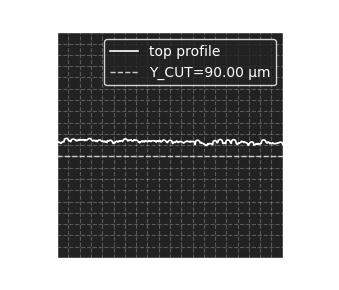

✔ saved → dem_runs/200x200_4,4,1_0.4,0.4,0.2_NA_20251011-195505/top_profile.png
✔ raw profile saved → dem_runs/200x200_4,4,1_0.4,0.4,0.2_NA_20251011-195505/baseline_profile.npz


In [9]:
import json, time, hashlib
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display

# ===== option =====
SNAPSHOT_SOURCE    = "AUTO"      # "AUTO" | "DEM_BASE" | "CURRENT"
REFRESH_DEM_BASE   = False       # True
FORCE_NEW_OUTDIR   = False       # True | False
BUF_RES            = 150         # Shapely buffer
USE_Y_CUT          = True
XS_SAMPLES         = 400         
PLOT_PROFILE       = True

def _fmt_num(x, nd=3):
    if x is None: return "NA"
    try:
        xi = float(x)
    except Exception:
        return str(x)
    if abs(xi - round(xi)) < 1e-9:
        return str(int(round(xi)))
    s = f"{xi:.{nd}f}".rstrip("0").rstrip(".")
    return s if s else "0"

def _fmt_csv(*vals):
    return ",".join(_fmt_num(v) for v in vals)

def _arr_sig(a):
    a = np.asarray(a)
    return (a.shape, float(np.sum(a)) if a.size else 0.0)

def _globals_ok():
    req = ['domain_width','domain_height','pos','rad','typ']
    return all(k in globals() for k in req)

def _hash_state(W, H, POS, RAD, TYP):
    arrs = [
        np.array([float(W), float(H)], dtype=np.float64),
        np.asarray(POS, dtype=np.float64).ravel(),
        np.asarray(RAD, dtype=np.float64).ravel(),
        np.asarray(TYP, dtype=np.int64).ravel(),
    ]
    h = hashlib.sha1()
    for a in arrs:
        h.update(a.tobytes()); h.update(str(a.shape).encode()); h.update(str(a.dtype).encode())
    return h.hexdigest()

SRC_REQ = SNAPSHOT_SOURCE.strip().upper()
reason = ""
use_current = False

if SRC_REQ == "CURRENT":
    if not _globals_ok():
        raise RuntimeError("CURRENT mode requires globals: domain_width, domain_height, pos, rad, typ")
    use_current = True
elif SRC_REQ == "DEM_BASE":
    if 'DEM_BASE' not in globals():
        raise RuntimeError("DEM_BASE not found. Run Cell 5.0 (snapshot) once right after DEM.")
    use_current = False
elif SRC_REQ == "AUTO":
    cur_hash = None
    if 'LAST_DEM_STATE' in globals():
        try:
            cur_hash = _hash_state(LAST_DEM_STATE['W'], LAST_DEM_STATE['H'],
                                   LAST_DEM_STATE['pos'], LAST_DEM_STATE['rad'], LAST_DEM_STATE['typ'])
        except Exception:
            cur_hash = None
    if 'DEM_BASE' not in globals():
        if not _globals_ok():
            raise RuntimeError("AUTO mode: DEM_BASE missing and CURRENT globals incomplete.")
        use_current = True; reason = "DEM_BASE missing"
    else:
        db_hash = DEM_BASE.get('hash', None)
        if (cur_hash is not None) and (db_hash is not None):
            use_current = (cur_hash != db_hash)
            reason = ("hash differs" if use_current else "hash equal")
        else:
            if _globals_ok():
                dbW = float(DEM_BASE['domain_width']); dbH = float(DEM_BASE['domain_height'])
                gw  = float(globals().get('domain_width')); gh = float(globals().get('domain_height'))
                same_wh = (abs(dbW-gw)<1e-12 and abs(dbH-gh)<1e-12)
                same_pos = _arr_sig(DEM_BASE['pos']) == _arr_sig(np.asarray(pos))
                same_rad = _arr_sig(DEM_BASE['rad']) == _arr_sig(np.asarray(rad))
                same_typ = _arr_sig(DEM_BASE['typ']) == _arr_sig(np.asarray(typ))
                use_current = not (same_wh and same_pos and same_rad and same_typ)
                reason = ("DEM_BASE differs from CURRENT" if use_current else "DEM_BASE matches CURRENT")
            else:
                use_current = False; reason = "CURRENT globals incomplete → using DEM_BASE"
else:
    raise ValueError("SNAPSHOT_SOURCE must be 'AUTO', 'DEM_BASE', or 'CURRENT'.")

if use_current:
    DW = float(domain_width)
    DH = float(domain_height)
    POS = np.asarray(pos, float).copy()
    RAD = np.asarray(rad, float).copy()
    TYP = np.asarray(typ, int).copy()
    SRC = "CURRENT"
else:
    DW = float(DEM_BASE['domain_width'])
    DH = float(DEM_BASE['domain_height'])
    POS = DEM_BASE['pos'].copy()
    RAD = DEM_BASE['rad'].copy()
    TYP = DEM_BASE['typ'].copy()
    SRC = "DEM_BASE"

print(f"[info] Source selected = {SRC}" + (f"  ({reason})" if reason else ""))

if REFRESH_DEM_BASE and (SRC == "CURRENT"):
    from shapely.geometry import box as shapely_box
    DEM_BASE = {
        'domain_width' : float(DW),
        'domain_height': float(DH),
        'domain_poly'  : shapely_box(0.0, 0.0, float(DW), float(DH)),
        'pos'          : np.array(POS, copy=True),
        'rad'          : np.array(RAD, copy=True),
        'typ'          : np.array(TYP, copy=True),
        'hash'         : _hash_state(DW, DH, POS, RAD, TYP),
    }
    print("DEM_BASE snapshot refreshed from CURRENT.")

Y_CUT = float(DH * 0.45)

RUNS_DIR = Path("./dem_runs"); RUNS_DIR.mkdir(parents=True, exist_ok=True)

if ('RUN_DIR' in globals()) and Path(RUN_DIR).exists() and (not FORCE_NEW_OUTDIR):
    OUT_DIR = Path(RUN_DIR)
else:
    D1v, D2v, D3v = globals().get('D1'), globals().get('D2'), globals().get('D3')
    f1v, f2v, f3v = globals().get('f1'), globals().get('f2'), globals().get('f3')
    SEEDv         = globals().get('SEED')
    domain_str = f"{_fmt_num(DW)}x{_fmt_num(DH)}"
    size_str   = _fmt_csv(D1v, D2v, D3v)
    frac_str   = _fmt_csv(f1v, f2v, f3v)
    seed_str   = str(SEEDv) if SEEDv is not None else "NA"
    base_run_name = f"{domain_str}_{size_str}_{frac_str}_{seed_str}"
    OUT_DIR = RUNS_DIR / base_run_name
    if OUT_DIR.exists():
        ts = time.strftime("%Y%m%d-%H%M%S")
        OUT_DIR = RUNS_DIR / f"{base_run_name}_{ts}"
    OUT_DIR.mkdir(parents=True, exist_ok=True)
print(f"[save] Output folder = {OUT_DIR.resolve()}")

def top_surface_profile(centers, radii, xs, H_clip):
    if centers.size == 0:
        return np.zeros_like(xs)
    y_top = np.zeros_like(xs, dtype=float)
    for k, x in enumerate(xs):
        dx  = np.abs(centers[:,0] - x)
        msk = dx <= radii
        if not np.any(msk): continue
        yi  = centers[msk,1]; ri  = radii[msk]; dxm = dx[msk]
        cap = yi + np.sqrt(np.maximum(ri*ri - dxm*dxm, 0.0))
        y_top[k] = float(np.max(cap))
    return np.clip(y_top, 0.0, H_clip)

cam_mask = (TYP == 1) | (TYP == 2)
se_mask  = (TYP == 3)
pos_cam = POS[cam_mask]; rad_cam = RAD[cam_mask]
pos_se  = POS[se_mask];  rad_se  = RAD[se_mask]

xs    = np.linspace(0.0, DW, XS_SAMPLES)
y_top = top_surface_profile(POS, RAD, xs, DH)

H_max  = float(np.max(y_top)) if y_top.size else 0.0
y_mean = float(np.mean(y_top)) if y_top.size else 0.0
Ra     = float(np.mean(np.abs(y_top - y_mean))) if y_top.size else 0.0
Rq     = float(np.sqrt(np.mean((y_top - y_mean)**2))) if y_top.size else 0.0
Rpv    = float(np.max(y_top) - np.min(y_top)) if y_top.size else 0.0

try:
    from shapely.geometry import Point, Polygon, box as shapely_box
    from shapely.ops import unary_union

    EPS_DRAW = 0.0
    def _buf(r): return max(0.0, float(r) - EPS_DRAW)

    CAM_union = (unary_union([Point(float(x),float(y)).buffer(_buf(float(rr)), resolution=BUF_RES)
                               for (x,y), rr in zip(pos_cam, rad_cam)])
                 if pos_cam.size else Polygon())
    SE_union  = (unary_union([Point(float(x),float(y)).buffer(_buf(float(rr)), resolution=BUF_RES)
                               for (x,y), rr in zip(pos_se, rad_se)])
                 if pos_se.size else Polygon())
    unions      = [g for g in (CAM_union, SE_union) if (g is not None and not g.is_empty)]
    SOLID_union = unary_union(unions) if unions else Polygon()

    domain_full = shapely_box(0.0, 0.0, DW, DH)
    if USE_Y_CUT:
        H_cut = float(np.clip(Y_CUT, 0.0, DH))
        domain_eff = shapely_box(0.0, 0.0, DW, H_cut)
        CAM_eff = CAM_union.intersection(domain_eff) if not CAM_union.is_empty else Polygon()
        SE_eff  = SE_union.intersection(domain_eff)  if not SE_union.is_empty  else Polygon()
        overlap_eff = CAM_eff.intersection(SE_eff)
        A_dom   = domain_eff.area
        A_cam   = CAM_eff.area
        A_se    = SE_eff.area
        A_ov    = overlap_eff.area
        A_union = A_cam + A_se - A_ov

        phi_eff      = (A_union / A_dom) if A_dom > 0 else 0.0
        phi_cam_excl = (max(0.0, A_cam - A_ov) / A_dom) if A_dom > 0 else 0.0
        phi_se_excl  = (max(0.0, A_se  - A_ov) / A_dom) if A_dom > 0 else 0.0
        phi_overlap  = (A_ov / A_dom) if A_dom > 0 else 0.0

        solid_full = SOLID_union.intersection(domain_full) if not SOLID_union.is_empty else Polygon()
        phi_full   = (solid_full.area / domain_full.area) if domain_full.area > 0 else 0.0

        print("\n===== Packing / Surface metrics — y-cut =====")
        print(f"  Source = {SRC}")
        print(f"  Y_CUT = {H_cut:.4f} µm (0 ≤ y ≤ Y_CUT)")
        print(f"  φ_eff (union)      = {phi_eff*100:.3f}%")
        print(f"  ├─ φ_CAM_exclusive = {phi_cam_excl*100:.3f}%")
        print(f"  ├─ φ_SE_exclusive  = {phi_se_excl*100:.3f}%")
        print(f"  └─ φ_overlap       = {phi_overlap*100:.3f}%   (ideal ~0%)")
        print(f"  Ra = {Ra:.4f} µm,  Rq = {Rq:.4f} µm,  P–V = {Rpv:.4f} µm")
        print(f"  (ref) φ_full (0–H_box) = {phi_full*100:.3f}%")

        txt_path = OUT_DIR / "baseline_ycut_metrics.txt"
        with open(txt_path, "w", encoding="utf-8") as f:
            f.write("===== Packing / Surface metrics — y-cut =====\n")
            f.write(f"Source = {SRC}\n")
            f.write(f"Y_CUT = {H_cut:.4f} µm (0 ≤ y ≤ Y_CUT)\n")
            f.write(f"φ_eff (union)      = {phi_eff*100:.3f}%\n")
            f.write(f"├─ φ_CAM_exclusive = {phi_cam_excl*100:.3f}%\n")
            f.write(f"├─ φ_SE_exclusive  = {phi_se_excl*100:.3f}%\n")
            f.write(f"└─ φ_overlap       = {phi_overlap*100:.3f}%   (ideal ~0%)\n")
            f.write(f"Ra = {Ra:.4f} µm,  Rq = {Rq:.4f} µm,  P–V = {Rpv:.4f} µm\n")
            f.write(f"(ref) φ_full (0–H_box) = {phi_full*100:.3f}%\n")
        print(f" saved → {txt_path}")

        meta_path = OUT_DIR / "metadata.json"
        try:
            meta = json.loads(meta_path.read_text(encoding="utf-8")) if meta_path.exists() else {}
        except Exception:
            meta = {}
        meta.setdefault("snapshots", {})
        meta["snapshots"]["dem_baseline_ycut"] = {
            "source": SRC, "Y_CUT_um": H_cut,
            "phi_eff_union": phi_eff,
            "phi_cam_exclusive": phi_cam_excl,
            "phi_se_exclusive": phi_se_excl,
            "phi_overlap": phi_overlap,
            "Ra_um": Ra, "Rq_um": Rq, "Rpv_um": Rpv,
            "phi_full_0_to_H": phi_full,
        }
        meta_path.write_text(json.dumps(meta, ensure_ascii=False, indent=2), encoding="utf-8")
        print(f" metadata.json updated → snapshots.dem_baseline_ycut")
    else:
        solid_full = SOLID_union.intersection(domain_full) if not SOLID_union.is_empty else Polygon()
        phi_full   = (solid_full.area / domain_full.area) if domain_full.area > 0 else 0.0
        print("\n===== Packing / Surface metrics (full box) =====")
        print(f"  Source = {SRC}")
        print(f"  φ_full (0–H_box) = {phi_full*100:.3f}%")

    try:
        import ezdxf
        HAVE_EZDXF = True
    except Exception:
        HAVE_EZDXF = False

    def _add_poly_to_dxf(msp, geom, color, layer=None):
        if (geom is None) or getattr(geom, "is_empty", True):
            return
        from shapely.geometry import Polygon as _Poly
        geoms = list(geom.geoms) if hasattr(geom, "geoms") else [geom]
        for g in geoms:
            if not isinstance(g, _Poly): continue
            ext = list(g.exterior.coords)
            if len(ext) > 1:
                msp.add_lwpolyline(ext[:-1], close=True,
                                   dxfattribs={'color': color, **({'layer': layer} if layer else {})})
            for hole in g.interiors:
                hs = list(hole.coords)
                if len(hs) > 1:
                    msp.add_lwpolyline(hs[:-1], close=True,
                                       dxfattribs={'color': color, **({'layer': layer} if layer else {})})

    def _save_dxf(path, cam_g, se_g, W, H, use_layers=True):
        if not HAVE_EZDXF:
            print(f"[skip] install ezdxf or skip: {path}"); return
        doc = ezdxf.new('R2010'); msp = doc.modelspace()
        if use_layers:
            for name, col in [('FRAME', 7), ('CAM', 5), ('SE', 3)]:
                try: doc.layers.new(name=name, dxfattribs={'color': col})
                except ezdxf.DXFError: pass
        frame_attr = {'color': 7} if not use_layers else {'layer': 'FRAME'}
        for a, b in [((0,0),(W,0)), ((W,0),(W,H)), ((W,H),(0,H)), ((0,H),(0,0))]:
            msp.add_line(a, b, dxfattribs=frame_attr)
        if cam_g is not None and not cam_g.is_empty:
            _add_poly_to_dxf(msp, cam_g, color=5, layer=('CAM' if use_layers else None))
        if se_g is not None and not se_g.is_empty:
            _add_poly_to_dxf(msp, se_g, color=3, layer=('SE' if use_layers else None))
        doc.saveas(str(path)); print(f" DXF saved → {path}")

    _save_dxf(OUT_DIR / "baseline_full.dxf", CAM_union, SE_union, DW, DH)
    if USE_Y_CUT:
        _save_dxf(OUT_DIR / "baseline_ycut.dxf", CAM_eff, SE_eff, DW, H_cut)

except Exception as e:
    print("\n[Info] Shapely union exception:", e)
    print(f"Ra = {Ra:.4f} µm,  Rq = {Rq:.4f} µm,  P–V = {Rpv:.4f} µm  (profile only)")

if PLOT_PROFILE and y_top.size:
    fig, ax = plt.subplots(figsize=(8, 3))
    ax.plot(xs, y_top, lw=1.2, label='top profile', color='w')
    if USE_Y_CUT:
        ax.axhline(float(np.clip(Y_CUT, 0.0, DH)), ls='--', lw=1.0,
                   label=f'Y_CUT={float(np.clip(Y_CUT,0,DH)):.2f} µm', color='0.8')
    ax.set_facecolor('#222')
    set_axes(ax, DW, max(DH, H_max*1.05),
             show_axes=True, step_x=TICK_STEP_X, step_y=TICK_STEP_Y, grid=True)
    ax.set_xlim(0, DW); ax.set_ylim(0, max(DH, H_max*1.05))
    leg = ax.legend(facecolor='#222', edgecolor='w'); [t.set_color('w') for t in leg.get_texts()]
    ax.set_title(f"Top surface profile (source={SRC})", color='w')
    plt.tight_layout()
    display(fig)
    fig_path = OUT_DIR / "top_profile.png"
    fig.savefig(fig_path, dpi=300, bbox_inches='tight'); plt.close(fig)
    print(f" saved → {fig_path}")

np.savez_compressed(OUT_DIR/"baseline_profile.npz", xs=xs, y_top=y_top, source=np.array([SRC]))
print(f"raw profile saved → {OUT_DIR/'baseline_profile.npz'}")

In [10]:
import time, json
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Point, Polygon, MultiPolygon, GeometryCollection, box as shapely_box
from shapely.ops import unary_union

# ---------- option ----------
SOURCE_MODE       = "CURRENT"       # "AUTO" | "DEM_BASE" | "CURRENT"
BUF_RES           = 64
OPEN_RES          = 128
INJECT_CAM_GAPS   = True
GAP_METHOD        = "asym_open"     # "opening" | "asym_open" | "shrink_per_disk"
GAP_UNITS         = "um"            # "um" | "d_SE"
CAM_GAP_EPS       = 1.2  
ASYM_GROW_RATIO   = 0.96 
USE_EPS_SCAN      = True
EPS_SCAN_LO       = 0.6
EPS_SCAN_HI       = 1.4
EPS_SCAN_STEPS    = 9
MAX_AREA_DROP_PCT = 12.0
HARD_MAX_DROP_PCT = 18.0
SELECT_EPS_STRATEGY = "largest_ok"
PREFER_SPLITS       = True
DO_TOP_COMPRESS   = True
Y_CROP_UM         = 90
APPLY_CAM_SHRINK  = False
CAM_SHRINK_EPS    = 0.0
SHRINK_RES        = 64

def _fmt_num(x, nd=3):
    if x is None: return "NA"
    try:
        xv = float(x)
    except Exception:
        return str(x)
    if abs(xv - round(xv)) < 1e-9:
        return str(int(round(xv)))
    s = f"{xv:.{nd}f}".rstrip("0").rstrip(".")
    return s if s else "0"

def _fmt_csv(*vals):
    return ",".join(_fmt_num(v) for v in vals)

RUNS_DIR = Path("./dem_runs"); RUNS_DIR.mkdir(parents=True, exist_ok=True)
if 'RUN_DIR' in globals() and Path(RUN_DIR).exists():
    OUT_DIR = Path(RUN_DIR)
else:
    D1v, D2v, D3v = globals().get('D1'), globals().get('D2'), globals().get('D3')
    f1v, f2v, f3v = globals().get('f1'), globals().get('f2'), globals().get('f3')
    SEEDv         = globals().get('SEED')
    domW = float(globals().get('domain_width')); domH = float(globals().get('domain_height'))
    base_run_name = f"{_fmt_num(domW)}x{_fmt_num(domH)}_{_fmt_csv(D1v,D2v,D3v)}_{_fmt_csv(f1v,f2v,f3v)}_{SEEDv if SEEDv is not None else 'NA'}"
    candidates = sorted(RUNS_DIR.glob(base_run_name+"*"),
                        key=lambda p: p.stat().st_mtime if p.exists() else 0, reverse=True)
    OUT_DIR = candidates[0] if candidates else (RUNS_DIR / base_run_name)
    if OUT_DIR.exists() and not candidates:
        ts = time.strftime("%Y%m%d-%H%M%S")
        OUT_DIR = RUNS_DIR / f"{base_run_name}_{ts}"
    OUT_DIR.mkdir(parents=True, exist_ok=True)
print(f"[save] Output folder = {OUT_DIR.resolve()}")

log_lines = []
def _log(msg):
    print(msg); log_lines.append(msg)

def _globals_ok():
    return all(k in globals() for k in ['domain_width','domain_height','pos','rad','typ'])

SRC_REQ = (SOURCE_MODE or "CURRENT").upper()
if SRC_REQ == "DEM_BASE":
    if 'DEM_BASE' not in globals():
        raise RuntimeError("DEM_BASE not found. Run immediately after DEM to capture base.")
    W0 = float(DEM_BASE['domain_width']);  H0 = float(DEM_BASE['domain_height'])
    POS = np.array(DEM_BASE['pos'], copy=True); RAD = np.array(DEM_BASE['rad'], copy=True); TYP = np.array(DEM_BASE['typ'], copy=True)
    SRC = "DEM_BASE"
elif SRC_REQ == "CURRENT":
    if not _globals_ok():
        raise RuntimeError("CURRENT requires globals: domain_width, domain_height, pos, rad, typ")
    W0 = float(domain_width); H0 = float(domain_height)
    POS = np.asarray(pos, float).copy(); RAD = np.asarray(rad, float).copy(); TYP = np.asarray(typ, int).copy()
    SRC = "CURRENT"
else:  # AUTO
    if 'DEM_BASE' in globals():
        W0 = float(DEM_BASE['domain_width']);  H0 = float(DEM_BASE['domain_height'])
        POS = np.array(DEM_BASE['pos'], copy=True); RAD = np.array(DEM_BASE['rad'], copy=True); TYP = np.array(DEM_BASE['typ'], copy=True)
        SRC = "DEM_BASE"
    else:
        if not _globals_ok():
            raise RuntimeError("AUTO: no DEM_BASE and CURRENT globals missing.")
        W0 = float(domain_width); H0 = float(domain_height)
        POS = np.asarray(pos, float).copy(); RAD = np.asarray(rad, float).copy(); TYP = np.asarray(typ, int).copy()
        SRC = "CURRENT"
_log(f"[info] SOURCE_MODE={SOURCE_MODE} → using {SRC} (W0={W0:.6f}, H0={H0:.6f})")

W_work = float(W0); H_work = float(H0)
domain_poly_work = shapely_box(0.0, 0.0, W_work, H_work)

radius_1 = float(D1)*0.5
radius_2 = float(D2)*0.5
radius_3 = float(D3)*0.5

pos1 = POS[TYP == 1]
pos2 = POS[TYP == 2]

circles_cam1 = [Point(float(x), float(y)).buffer(radius_1, resolution=BUF_RES) for (x, y) in pos1] if len(pos1) else []
circles_cam2 = [Point(float(x), float(y)).buffer(radius_2, resolution=BUF_RES) for (x, y) in pos2] if len(pos2) else []
cam_union_before = unary_union(circles_cam1 + circles_cam2) if (circles_cam1 or circles_cam2) else Polygon()
cam_union_before = cam_union_before.intersection(domain_poly_work).buffer(0)

def _eps_um(val):
    if GAP_UNITS.lower() == "d_se":
        return float(val) * float(D3)
    return float(val)

EPS0 = _eps_um(CAM_GAP_EPS)
EPS_RANGE_LO = _eps_um(EPS_SCAN_LO)
EPS_RANGE_HI = _eps_um(EPS_SCAN_HI)

def _n_comp(g):
    if g is None or g.is_empty: return 0
    if isinstance(g, (MultiPolygon, GeometryCollection)):
        return sum(1 for gg in g.geoms if isinstance(gg, Polygon))
    return 1 if isinstance(g, Polygon) else 0

def _opening(geom, eps):
    if geom is None or geom.is_empty: return geom
    g = geom.buffer(-eps, resolution=OPEN_RES)
    if g.is_empty: return g
    g = g.buffer(+eps, resolution=OPEN_RES)
    return g.intersection(domain_poly_work).buffer(0)

def _asym_open(geom, eps, grow_ratio):
    if geom is None or geom.is_empty: return geom
    g = geom.buffer(-eps, resolution=OPEN_RES)
    if g.is_empty: return g
    g = g.buffer(+eps*grow_ratio, resolution=OPEN_RES)
    return g.intersection(domain_poly_work).buffer(0)

def _shrink_per_disk(eps):
    shr1 = [c.buffer(-eps, resolution=BUF_RES) for c in circles_cam1]
    shr2 = [c.buffer(-eps, resolution=BUF_RES) for c in circles_cam2]
    gs = [g for g in (shr1+shr2) if (g is not None and (not g.is_empty))]
    if not gs:
        return Polygon()
    g = unary_union(gs)
    return g.intersection(domain_poly_work).buffer(0)

cam_union_after = cam_union_before
picked_eps = None
picked_method = GAP_METHOD
picked_drop = None
picked_comps0 = _n_comp(cam_union_before)
picked_comps1 = picked_comps0
picked_strategy = None

if HARD_MAX_DROP_PCT < MAX_AREA_DROP_PCT:
    HARD_MAX_DROP_PCT = MAX_AREA_DROP_PCT + 5.0

if INJECT_CAM_GAPS and (cam_union_before is not None) and (not cam_union_before.is_empty):
    A0 = cam_union_before.area
    comps0 = _n_comp(cam_union_before)

    if GAP_METHOD in ("opening", "asym_open") and USE_EPS_SCAN:
        _log(f"[open/scan] ε in [{EPS_RANGE_LO}, {EPS_RANGE_HI}] μm, steps={EPS_SCAN_STEPS}, area_limit={MAX_AREA_DROP_PCT}% (hard {HARD_MAX_DROP_PCT}%)")
        eps_list = np.linspace(EPS_RANGE_LO, EPS_RANGE_HI, int(EPS_SCAN_STEPS))
        oks = []     # (e, drop_pct, comps, geom)
        logs = []
        for e in eps_list:
            if GAP_METHOD == "opening":
                g = _opening(cam_union_before, e)
            else:
                g = _asym_open(cam_union_before, e, ASYM_GROW_RATIO)
            g = g.intersection(domain_poly_work).buffer(0) if (g is not None) else None
            A1 = g.area if (g and not g.is_empty) else 0.0
            drop_pct = (1.0 - A1/max(A0,1e-12))*100.0
            comps   = _n_comp(g) if (g and not g.is_empty) else 0
            flag_hard = (drop_pct > HARD_MAX_DROP_PCT) or (g is None) or (g.is_empty)
            ok = (drop_pct <= MAX_AREA_DROP_PCT) and (not flag_hard)
            state = "OK" if ok else "NG"
            logs.append(f"[open/scan] ε={_fmt_num(e,3)} μm → {state} | comps {comps0}->{comps} | ΔA={drop_pct:6.2f}%")
            if ok:
                oks.append((float(e), float(drop_pct), int(comps), g))
        for line in logs: _log(line)

        pick = None
        if oks:
            if SELECT_EPS_STRATEGY == "largest_ok":
                if PREFER_SPLITS:
                    oks_sorted = sorted(oks, key=lambda t: (t[0], t[2]-comps0, -t[1]), reverse=True)
                else:
                    oks_sorted = sorted(oks, key=lambda t: (t[0], -t[1]))[::-1]
                pick = oks_sorted[0]
                picked_strategy = "largest_ok"
            else:
                pos = [t for t in oks if t[1] > 1e-3]
                if pos:
                    pick = sorted(pos, key=lambda t: (t[1], abs(t[2]-comps0), t[0]))[0]
                else:
                    pick = sorted(oks, key=lambda t: (abs(t[2]-comps0), -t[0]))[0]
                picked_strategy = "min_positive_drop"

        if pick is not None:
            picked_eps, picked_drop, picked_comps1, cam_union_after = pick
            _log(f" opening picked ({picked_strategy}): ε*={_fmt_num(picked_eps)} μm | ΔA={picked_drop:.2f}% | comps {comps0}->{picked_comps1}")
        else:
            _log("! scan found no acceptable ε — fallback to single-shot below")
            if GAP_METHOD == "opening":
                cam_union_after = _opening(cam_union_before, EPS0)
            else:
                cam_union_after = _asym_open(cam_union_before, EPS0, ASYM_GROW_RATIO)
            picked_eps = float(EPS0); picked_strategy = "single_shot"
    else:
        if GAP_METHOD == "opening":
            cam_union_after = _opening(cam_union_before, EPS0)
        elif GAP_METHOD == "asym_open":
            cam_union_after = _asym_open(cam_union_before, EPS0, ASYM_GROW_RATIO)
        elif GAP_METHOD == "shrink_per_disk":
            cam_union_after = _shrink_per_disk(EPS0)
        else:
            _log(f"[gap] unknown GAP_METHOD={GAP_METHOD}; skip.")
        picked_eps = float(EPS0); picked_strategy = "single_shot"

    if cam_union_after is None or cam_union_after.is_empty:
        _log("[gap] result empty — keeping original union.")
        cam_union_after = cam_union_before
        picked_drop = 100.0
        picked_comps1 = _n_comp(cam_union_after)
    else:
        A1 = cam_union_after.area
        drop_pct = (1.0 - A1/max(A0,1e-12))*100.0
        picked_drop = drop_pct if (picked_drop is None) else picked_drop
        if drop_pct > HARD_MAX_DROP_PCT:
            _log(f"[gap] ΔA={drop_pct:.2f}% > HARD_MAX_DROP_PCT — rollback to original union.")
            cam_union_after = cam_union_before
            picked_comps1 = _n_comp(cam_union_after)
else:
    _log("ℹ gap injection skipped or empty geometry.")

def _draw_geom(ax, geom, fc="#1f77b4", ec="k", alpha=0.85, lw=0.6):
    if geom is None or geom.is_empty:
        return
    geoms = []
    if isinstance(geom, (MultiPolygon, GeometryCollection)):
        geoms = [g for g in geom.geoms if isinstance(g, Polygon)]
    elif isinstance(geom, Polygon):
        geoms = [geom]
    for g in geoms:
        xy = np.asarray(g.exterior.coords)
        ax.fill(xy[:,0], xy[:,1], facecolor=fc, edgecolor=ec, alpha=alpha, lw=lw)
        for h in g.interiors:
            hxy = np.asarray(h.coords)
            ax.fill(hxy[:,0], hxy[:,1], facecolor="white", edgecolor="none", alpha=1.0)

def _save_geom_png(path_png, cam_geom, void_geom, W, H, title=""):
    fig, ax = plt.subplots(figsize=(8*W/H if H>0 else 8, 8))
    ax.set_xlim(0,W); ax.set_ylim(0,H); ax.set_aspect('equal')
    ax.grid(True, ls='--', alpha=0.3)
    ax.plot([0,W,W,0,0],[0,0,H,H,0],'k-',lw=1.2)
    if void_geom is not None and (not void_geom.is_empty):
        _draw_geom(ax, void_geom, fc='#f2f2f2', ec='none', alpha=1.0, lw=0.0)
    if cam_geom is not None and (not cam_geom.is_empty):
        _draw_geom(ax, cam_geom, fc='royalblue', ec='k', alpha=0.85, lw=0.4)
    ax.set_title(title, fontsize=12); plt.tight_layout()
    fig.savefig(path_png, dpi=300, bbox_inches='tight'); plt.close(fig)

def _save_overlay_removed_on_after(path_png, cam_before, cam_after, W, H, title=""):
    removed = None
    try:
        removed = cam_before.difference(cam_after)
    except Exception:
        pass
    fig, ax = plt.subplots(figsize=(8*W/H if H>0 else 8, 8))
    ax.set_xlim(0,W); ax.set_ylim(0,H); ax.set_aspect('equal'); ax.grid(True, ls='--', alpha=0.3)
    ax.plot([0,W,W,0,0],[0,0,H,H,0],'k-',lw=1.2)
    if cam_after is not None and (not cam_after.is_empty):
        _draw_geom(ax, cam_after, fc='royalblue', ec='k', alpha=0.85, lw=0.4)
    if removed is not None and (not removed.is_empty):
        _draw_geom(ax, removed,   fc='red',       ec='none', alpha=0.75, lw=0.0)
    ax.set_title(title, fontsize=12); plt.tight_layout()
    fig.savefig(path_png, dpi=300, bbox_inches='tight'); plt.close(fig)

def _save_symdiff(path_png, cam_before, cam_after, W, H, title=""):
    symd = None
    try:
        symd = cam_before.symmetric_difference(cam_after)
    except Exception:
        pass
    fig, ax = plt.subplots(figsize=(8*W/H if H>0 else 8, 8))
    ax.set_xlim(0,W); ax.set_ylim(0,H); ax.set_aspect('equal'); ax.grid(True, ls='--', alpha=0.3)
    ax.plot([0,W,W,0,0],[0,0,H,H,0],'k-',lw=1.2)
    if symd is not None and (not symd.is_empty):
        _draw_geom(ax, symd, fc='#ff7f0e', ec='k', alpha=0.85, lw=0.3)
    ax.set_title(title, fontsize=12); plt.tight_layout()
    fig.savefig(path_png, dpi=300, bbox_inches='tight'); plt.close(fig)

void_before = domain_poly_work.difference(cam_union_before) if (cam_union_before and not cam_union_before.is_empty) else domain_poly_work
void_after  = domain_poly_work.difference(cam_union_after)  if (cam_union_after  and not cam_union_after.is_empty)  else domain_poly_work

_save_geom_png(OUT_DIR / "step1_gap_before.png", cam_union_before, void_before, W_work, H_work,
               title=f"Before (CAM union) — comps={_n_comp(cam_union_before)}")
_save_geom_png(OUT_DIR / "step1_gap_after.png",  cam_union_after,  void_after,  W_work, H_work,
               title=f"After  ({GAP_METHOD}, ε={_fmt_num(picked_eps) if picked_eps is not None else 'NA'} μm) — comps={_n_comp(cam_union_after)}")

_save_overlay_removed_on_after(OUT_DIR / "step1_gap_delta_removed_on_after.png",
                               cam_union_before, cam_union_after, W_work, H_work,
                               title="Areas removed by gap (red) overlaid on AFTER")
_save_symdiff(OUT_DIR / "step1_gap_delta_symdiff.png",
              cam_union_before, cam_union_after, W_work, H_work,
              title="Symmetric difference (before ⊕ after)")

cam_union_step1 = cam_union_after
void_after_step1 = domain_poly_work.difference(cam_union_step1)

if DO_TOP_COMPRESS and (cam_union_step1 is not None) and (not cam_union_step1.is_empty):
    minx, miny, maxx, maxy = cam_union_step1.bounds
    new_H = float(maxy)
    if new_H < H_work:
        H_work = new_H
        domain_poly_work = shapely_box(0.0, 0.0, W_work, H_work)
        cam_union_step1  = cam_union_step1.intersection(domain_poly_work).buffer(0)
        void_after_step1 = domain_poly_work.difference(cam_union_step1)
        _log(f" Domain height compressed to top of CAM: H = {H_work:.6f} µm")
_save_geom_png(OUT_DIR / "step1_top_compress.png", cam_union_step1, void_after_step1, W_work, H_work,
               title="Step 1 — After top compress")

did_crop = False
if (Y_CROP_UM is not None) and (float(Y_CROP_UM) < H_work):
    H_work = float(max(0.0, Y_CROP_UM))
    domain_poly_work = shapely_box(0.0, 0.0, W_work, H_work)
    cam_union_step1  = cam_union_step1.intersection(domain_poly_work).buffer(0)
    void_after_step1 = domain_poly_work.difference(cam_union_step1)
    _log(f"✂ Cropped domain to H = {H_work:.3f} µm")
    _save_geom_png(OUT_DIR / "step1_cropped.png", cam_union_step1, void_after_step1, W_work, H_work,
                   title=f"Step 1 — After crop={_fmt_num(Y_CROP_UM)} µm")
    did_crop = True

did_shrink = False
if APPLY_CAM_SHRINK and (CAM_SHRINK_EPS > 0.0) and (cam_union_step1 is not None) and (not cam_union_step1.is_empty):
    A_before = cam_union_step1.area
    cam_union_step1  = cam_union_step1.buffer(-float(CAM_SHRINK_EPS), resolution=SHRINK_RES)
    cam_union_step1  = cam_union_step1.intersection(domain_poly_work).buffer(0)
    void_after_step1 = domain_poly_work.difference(cam_union_step1)
    A_after  = cam_union_step1.area if (cam_union_step1 and not cam_union_step1.is_empty) else 0.0
    drop_pct2 = (1.0 - A_after/max(A_before,1e-12))*100.0
    _log(f"🔧 CAM shrink applied: ΔA ≈ {drop_pct2:.2f}%")
    did_shrink = True

_save_geom_png(OUT_DIR / "step1_final.png", cam_union_step1, void_after_step1, W_work, H_work,
               title=f"Step 1 — Final (method={GAP_METHOD}, ε={_fmt_num(picked_eps) if picked_eps is not None else 'NA'} µm)")

_total_area = domain_poly_work.area
_cam_area   = cam_union_step1.area if (cam_union_step1 and not cam_union_step1.is_empty) else 0.0
_void_area  = _total_area - _cam_area
_log(f"Step 1 areas | CAM: {_cam_area:.2f} ({(_cam_area/_total_area if _total_area>0 else 0.0):.2%}) | Void: {_void_area:.2f} ({(_void_area/_total_area if _total_area>0 else 0.0):.2%})")

log_path = OUT_DIR / "step1_opening_v2_report.txt"
with open(log_path, "w", encoding="utf-8") as f:
    f.write("\n".join(log_lines) + "\n")
print(f" saved LOG → {log_path}")

meta_path = OUT_DIR / "metadata.json"
try:
    meta = json.loads(meta_path.read_text(encoding="utf-8")) if meta_path.exists() else {}
except Exception:
    meta = {}
meta.setdefault("post_dem_steps", {})
meta["post_dem_steps"]["step1_opening_v2"] = {
    "source": SRC,
    "method": GAP_METHOD,
    "selected": {
        "strategy": picked_strategy,
        "eps": (None if picked_eps is None else float(picked_eps)),
        "drop_pct": (None if picked_drop is None else float(picked_drop)),
        "comps_before": int(picked_comps0),
        "comps_after": int(_n_comp(cam_union_step1)),
        "epsilon_range": {"lo": float(EPS_RANGE_LO), "hi": float(EPS_RANGE_HI), "steps": int(EPS_SCAN_STEPS)},
        "prefer_splits": bool(PREFER_SPLITS)
    },
    "params": {
        "BUF_RES": int(BUF_RES),
        "OPEN_RES": int(OPEN_RES),
        "INJECT_CAM_GAPS": bool(INJECT_CAM_GAPS),
        "GAP_UNITS": str(GAP_UNITS),
        "CAM_GAP_EPS": float(CAM_GAP_EPS),
        "ASYM_GROW_RATIO": float(ASYM_GROW_RATIO),
        "USE_EPS_SCAN": bool(USE_EPS_SCAN),
        "EPS_SCAN_LO": float(EPS_SCAN_LO),
        "EPS_SCAN_HI": float(EPS_SCAN_HI),
        "EPS_SCAN_STEPS": int(EPS_SCAN_STEPS),
        "MAX_AREA_DROP_PCT": float(MAX_AREA_DROP_PCT),
        "HARD_MAX_DROP_PCT": float(HARD_MAX_DROP_PCT),
        "SELECT_EPS_STRATEGY": str(SELECT_EPS_STRATEGY),
        "PREFER_SPLITS": bool(PREFER_SPLITS),
        "DO_TOP_COMPRESS": bool(DO_TOP_COMPRESS),
        "Y_CROP_UM": (float(Y_CROP_UM) if Y_CROP_UM is not None else None),
        "APPLY_CAM_SHRINK": bool(APPLY_CAM_SHRINK),
        "CAM_SHRINK_EPS": float(CAM_SHRINK_EPS),
        "SHRINK_RES": int(SHRINK_RES),
    },
    "areas_um2": {
        "A_total": float(_total_area),
        "A_cam": float(_cam_area),
        "A_void": float(_void_area)
    },
    "files": {
        "png": {
            "before": "step1_gap_before.png",
            "after": "step1_gap_after.png",
            "delta_removed_on_after": "step1_gap_delta_removed_on_after.png",
            "symdiff": "step1_gap_delta_symdiff.png",
            "top_compress": "step1_top_compress.png",
            "cropped": ("step1_cropped.png" if did_crop else None),
            "final": "step1_final.png",
        },
        "log": log_path.name
    }
}
meta_path.write_text(json.dumps(meta, ensure_ascii=False, indent=2), encoding="utf-8")
print(f" metadata.json updated → post_dem_steps.step1_opening_v2")

domain_width  = float(W_work)
domain_height = float(H_work)
domain_poly   = shapely_box(0.0, 0.0, domain_width, domain_height)

[save] Output folder = /mnt/c/Users/user/Desktop/cnn/segment-anything-2/dem_runs/200x200_4,4,1_0.4,0.4,0.2_NA_20251011-195505
[info] SOURCE_MODE=CURRENT → using CURRENT (W0=200.000000, H0=200.000000)


[open/scan] ε in [0.6, 1.4] μm, steps=9, area_limit=12.0% (hard 18.0%)


[open/scan] ε=0.6 μm → OK | comps 976->1146 | ΔA=  2.39%
[open/scan] ε=0.7 μm → OK | comps 976->1146 | ΔA=  2.78%
[open/scan] ε=0.8 μm → OK | comps 976->1146 | ΔA=  3.18%
[open/scan] ε=0.9 μm → OK | comps 976->1146 | ΔA=  3.57%
[open/scan] ε=1 μm → OK | comps 976->1146 | ΔA=  3.96%
[open/scan] ε=1.1 μm → OK | comps 976->1146 | ΔA=  4.35%
[open/scan] ε=1.2 μm → OK | comps 976->1146 | ΔA=  4.75%
[open/scan] ε=1.3 μm → OK | comps 976->1146 | ΔA=  5.14%
[open/scan] ε=1.4 μm → OK | comps 976->1146 | ΔA=  5.53%
✔ opening picked (largest_ok): ε*=1.4 μm | ΔA=5.53% | comps 976->1146


✔ Domain height compressed to top of CAM: H = 105.904888 µm


✂ Cropped domain to H = 90.000 µm


Step 1 areas | CAM: 11888.67 (66.05%) | Void: 6111.33 (33.95%)
✔ saved LOG → dem_runs/200x200_4,4,1_0.4,0.4,0.2_NA_20251011-195505/step1_opening_v2_report.txt
✔ metadata.json updated → post_dem_steps.step1_opening_v2


In [11]:
import os, math, json, time, warnings
from pathlib import Path
import numpy as np
from PIL import Image, ImageDraw
from matplotlib import pyplot as plt

def _fmt_num(x, nd=3):
    if x is None: return "NA"
    try:
        xv = float(x)
    except Exception:
        return str(x)
    if abs(xv - round(xv)) < 1e-9:
        return str(int(round(xv)))
    s = f"{xv:.{nd}f}".rstrip("0").rstrip(".")
    return s if s else "0"

def _fmt_csv(*vals):
    return ",".join(_fmt_num(v) for v in vals)

RUNS_DIR = Path("./dem_runs"); RUNS_DIR.mkdir(parents=True, exist_ok=True)

if 'RUN_DIR' in globals() and Path(RUN_DIR).exists():
    OUT_DIR = Path(RUN_DIR)
else:
    if 'DEM_BASE' in globals():
        DW = float(DEM_BASE['domain_width'])
        DH = float(DEM_BASE['domain_height'])
    else:
        DW = float(globals().get('domain_width'))
        DH = float(globals().get('domain_height'))
    D1v, D2v, D3v = globals().get('D1'), globals().get('D2'), globals().get('D3')
    f1v, f2v, f3v = globals().get('f1'), globals().get('f2'), globals().get('f3')
    SEEDv         = globals().get('SEED')
    domain_str = f"{_fmt_num(DW)}x{_fmt_num(DH)}"
    size_str   = _fmt_csv(D1v, D2v, D3v)
    frac_str   = _fmt_csv(f1v, f2v, f3v)
    seed_str   = str(SEEDv) if SEEDv is not None else "NA"
    base_run_name = f"{domain_str}_{size_str}_{frac_str}_{seed_str}"
    candidates = sorted(RUNS_DIR.glob(base_run_name+"*"),
                        key=lambda p: p.stat().st_mtime if p.exists() else 0, reverse=True)
    OUT_DIR = candidates[0] if candidates else (RUNS_DIR / base_run_name)
    if OUT_DIR.exists() and not candidates:
        ts = time.strftime("%Y%m%d-%H%M%S")
        OUT_DIR = RUNS_DIR / f"{base_run_name}_{ts}"
    OUT_DIR.mkdir(parents=True, exist_ok=True)

print(f"[save] Output folder = {OUT_DIR.resolve()}")

TOR_OUT = OUT_DIR

PIX_PER_UM_BASE      = 16.0   
MIN_GAP_TARGET_PX    = 5.0    
SUPER_SAMPLE_BASE    = 16     
SUPER_SAMPLE_MIN     = 8      
SUPER_SAMPLE_MAX     = 24     
HIRES_PIX_CAP        = 120_000_000  
RASTER_PIX_CAP       = 6_000_000    
POOL_THRESH          = 0.65         

def _read_eps_from_meta(meta_dict):
    pds = meta_dict.get("post_dem_steps", {})
    if "step1_opening_v2" in pds:
        sel = pds["step1_opening_v2"].get("selected", {})
        if isinstance(sel, dict) and ("eps" in sel):
            return float(sel["eps"])
    if "step1_opening_only" in pds:
        maybe = pds["step1_opening_only"]
        for k in ("eps", "epsilon", "used_eps_um", "selected_eps_um"):
            if k in maybe:
                try: return float(maybe[k])
                except: pass

    for key, val in pds.items():
        if isinstance(val, dict):
            for k in ("eps","epsilon","used_eps_um","selected_eps_um"):
                if k in val:
                    try: return float(val[k])
                    except: pass
            if "selected" in val and isinstance(val["selected"], dict):
                for k in ("eps","epsilon"):
                    if k in val["selected"]:
                        try: return float(val["selected"][k])
                        except: pass
    return None

OPENING_SELECTED_EPS_UM = None
try:
    meta_path = OUT_DIR / "metadata.json"
    if meta_path.exists():
        meta = json.loads(meta_path.read_text(encoding="utf-8"))
        OPENING_SELECTED_EPS_UM = _read_eps_from_meta(meta)
except Exception:
    OPENING_SELECTED_EPS_UM = None

PIX_PER_UM = float(PIX_PER_UM_BASE)
if OPENING_SELECTED_EPS_UM and OPENING_SELECTED_EPS_UM > 0:
    need_ppum = MIN_GAP_TARGET_PX / (2.0 * OPENING_SELECTED_EPS_UM)
    if need_ppum > PIX_PER_UM:
        PIX_PER_UM = need_ppum

domain_w_um = float(domain_width)
domain_h_um = float(domain_height)

def _dims(px_per_um):
    width_px  = int(round(domain_w_um * px_per_um))
    height_px = int(round(domain_h_um * px_per_um))
    return width_px, height_px

width_px, height_px = _dims(PIX_PER_UM)

tot_px = width_px * height_px
if tot_px > RASTER_PIX_CAP:
    scale = math.sqrt(RASTER_PIX_CAP / max(1, tot_px))
    PIX_PER_UM = max(4.0, PIX_PER_UM * scale)
    width_px, height_px = _dims(PIX_PER_UM)
    print(f"[auto-res] downscaled PIX_PER_UM by raster cap → {PIX_PER_UM:.3f} px/µm")

SUPER_SAMPLE = int(np.clip(SUPER_SAMPLE_BASE, SUPER_SAMPLE_MIN, SUPER_SAMPLE_MAX))
def _hi_px(SS): return width_px * height_px * SS * SS

if _hi_px(SUPER_SAMPLE) > HIRES_PIX_CAP:
    new_SS = int(max(SUPER_SAMPLE_MIN, math.floor(math.sqrt(HIRES_PIX_CAP / max(1, width_px*height_px)))))
    if new_SS < SUPER_SAMPLE:
        SUPER_SAMPLE = new_SS
        print(f"[mem-guard] SUPER_SAMPLE ↓ to {SUPER_SAMPLE} (hi-res cap)")
    if _hi_px(SUPER_SAMPLE) > HIRES_PIX_CAP:
        scale = math.sqrt(HIRES_PIX_CAP / max(1, _hi_px(SUPER_SAMPLE)))
        PIX_PER_UM = max(4.0, PIX_PER_UM * scale)
        width_px, height_px = _dims(PIX_PER_UM)
        print(f"[mem-guard] PIX_PER_UM ↓ to {PIX_PER_UM:.3f} px/µm (hi-res cap)")
        if _hi_px(SUPER_SAMPLE) > HIRES_PIX_CAP:
            SUPER_SAMPLE = int(max(SUPER_SAMPLE_MIN, math.floor(math.sqrt(HIRES_PIX_CAP / max(1, width_px*height_px)))))
            print(f"[mem-guard] SUPER_SAMPLE final ↓ to {SUPER_SAMPLE}")

print(f"[auto-res] using PIX_PER_UM={PIX_PER_UM:.3f} px/µm (ε={OPENING_SELECTED_EPS_UM})")
sx = float(PIX_PER_UM); sy = float(PIX_PER_UM)
print(f"[raster] domain=({domain_w_um:.3f} µm, {domain_h_um:.3f} µm) → image={width_px}×{height_px}px (sx={sx:.3f}, sy={sy:.3f} px/µm)")
print(f"[hi-res] SUPER_SAMPLE={SUPER_SAMPLE} → hires canvas ≈ {width_px*SUPER_SAMPLE}×{height_px*SUPER_SAMPLE} px "
      f"(~{_hi_px(SUPER_SAMPLE)/1e6:.1f} Mpx)")

from shapely.geometry import Polygon, MultiPolygon
from skimage.measure import block_reduce

def _poly_to_pixel_rings(poly: Polygon, sx: float, sy: float, W: int, H: int):
    def _ring_to_pts(ring):
        xs, ys = np.asarray(ring.coords.xy[0]), np.asarray(ring.coords.xy[1])
        xpix = xs * sx - 0.5
        ypix = (domain_h_um - ys) * sy - 0.5
        xpix = np.clip(xpix, 0.0, W - 1.0)
        ypix = np.clip(ypix, 0.0, H - 1.0)
        return list(map(tuple, np.stack([xpix, ypix], axis=1)))
    ext = _ring_to_pts(poly.exterior)
    holes = [_ring_to_pts(r) for r in poly.interiors]
    return ext, holes

def rasterize_geom(geom, sx: float, sy: float, W: int, H: int, SS: int, pool_thresh: float):
    if geom is None or getattr(geom, "is_empty", True):
        return np.zeros((H, W), dtype=bool)

    W2, H2 = W*SS, H*SS
    sx2, sy2 = sx*SS, sy*SS

    mask_hi = Image.new('1', (W2, H2), 0)
    draw = ImageDraw.Draw(mask_hi)

    geoms = list(geom.geoms) if isinstance(geom, MultiPolygon) else [geom]
    for g in geoms:
        ext, holes = _poly_to_pixel_rings(g, sx2, sy2, W2, H2)
        if len(ext) >= 3:
            draw.polygon(ext, outline=None, fill=1)
        for h in holes:
            if len(h) >= 3:
                draw.polygon(h, outline=None, fill=0)

    arr_hi = np.array(mask_hi, dtype=bool).astype(np.float32)  # 0/1 float
    arr = block_reduce(arr_hi, block_size=(SS, SS), func=np.mean) >= pool_thresh
    return arr.astype(bool)

cam_mask_bool = rasterize_geom(cam_union_step1, sx, sy, width_px, height_px, SUPER_SAMPLE, POOL_THRESH)
void_mask_bool = ~cam_mask_bool

unknown = ~(cam_mask_bool | void_mask_bool)
if unknown.any():
    print("[warn] unknown pixels exist on phase map; check rasterization.")

FORCE_MIN_GAP = False
MIN_GAP_PX = None
MIN_GAP_UM = None

gap_added = np.zeros_like(cam_mask_bool, dtype=bool)
gap_r_px = 0

if FORCE_MIN_GAP:
    try:
        from skimage import morphology
        if MIN_GAP_PX is not None:
            gap_r_px = int(max(0, round(MIN_GAP_PX)))
        else:
            gap_r_px = int(max(0, round((MIN_GAP_UM or 0.0) * max(sx, sy))))
        if gap_r_px > 0 and cam_mask_bool.any():
            selem = morphology.disk(gap_r_px)
            cam_shrunk = morphology.binary_erosion(cam_mask_bool, selem)
            ring = cam_mask_bool & (~cam_shrunk)
            cam_mask_bool = cam_shrunk
            gap_added = ring
            void_mask_bool = ~cam_mask_bool
    except Exception as e:
        print(f"[warn] artificial gap skipped: {e}")
        gap_r_px = 0

CONTACT_GUARD = True
PAD_UM = 0.5
PAD = max(1, int(round(PAD_UM * sy)))

def _ensure_contact(mask: np.ndarray, pad: int = 1):
    m = mask.copy(); H, W = m.shape
    if H > 1 and not m[0, :].any():      m[0, :]  = np.any(m[1:min(1+pad, H), :], axis=0)
    if H > 1 and not m[-1, :].any():     m[-1, :] = np.any(m[max(0, H-1-pad):H-1, :], axis=0)
    if W > 1 and not m[:, 0].any():      m[:, 0]  = np.any(m[:, 1:min(1+pad, W)], axis=1)
    if W > 1 and not m[:, -1].any():     m[:, -1] = np.any(m[:, max(0, W-1-pad):W-1], axis=1)
    return m

if CONTACT_GUARD:
    void_mask_bool = _ensure_contact(void_mask_bool, pad=PAD)

try:
    from scipy.ndimage import distance_transform_edt
    void_dt = distance_transform_edt(void_mask_bool)  # distance to nearest CAM pixel
    min_gap_est_px = int(2.0 * np.nanmin(void_dt[np.where(void_mask_bool)])) if void_mask_bool.any() else 0
    min_gap_est_um = (min_gap_est_px / max(1.0, float(PIX_PER_UM)))
    print(f"[debug] ~min gap (raster est) ≈ {min_gap_est_px} px ≈ {min_gap_est_um:.3f} µm")
except Exception as e:
    print(f"[debug] min gap estimate skipped: {e}")

phase_rgb = np.zeros((height_px, width_px, 3), dtype=np.uint8)
phase_rgb[cam_mask_bool]  = (0, 200, 0)      # CAM (non-conducting)
phase_rgb[void_mask_bool] = (128, 128, 128)  # VOID(conducting)
if gap_added.any():
    phase_rgb[gap_added]  = (255, 255, 0)    # GAP (calc-only)

phase_map_path = os.path.join(TOR_OUT, "phase_map_void_conducting.png")
Image.fromarray(phase_rgb).save(phase_map_path)
print(f" saved → {phase_map_path}" + ("  (with artificial gap)" if gap_added.any() else ""))

tot = phase_rgb.shape[0]*phase_rgb.shape[1]
print(f"[counts] CAM={(cam_mask_bool).sum()}  VOID={(void_mask_bool).sum()}  GAP={(gap_added).sum()}  total={tot}")

import porespy as ps

binary_mask = (void_mask_bool | gap_added).astype(bool)

touch_left  = bool(binary_mask[:, 0].any())
touch_right = bool(binary_mask[:, -1].any())
touch_top   = bool(binary_mask[0, :].any())
touch_bot   = bool(binary_mask[-1, :].any())
print("touches  left? ", touch_left, " | right? ", touch_right, " | top? ", touch_top, " | bottom?", touch_bot)

try:
    from skimage.measure import label
    def percolates(mask: np.ndarray, axis: int) -> bool:
        if not mask.any():
            return False
        lbl = label(mask, connectivity=1)
        if axis == 0:
            a = set(lbl[0, :].ravel().tolist()) - {0}
            b = set(lbl[-1, :].ravel().tolist()) - {0}
        else:
            a = set(lbl[:, 0].ravel().tolist()) - {0}
            b = set(lbl[:, -1].ravel().tolist()) - {0}
        return len(a.intersection(b)) > 0
except Exception:
    def percolates(mask: np.ndarray, axis: int) -> bool:
        return bool(mask[0, :].any() and mask[-1, :].any()) if axis == 0 else bool(mask[:, 0].any() and mask[:, -1].any())

def _solve_tau(mask: np.ndarray, axis: int):
    if not percolates(mask, axis):
        return None, "no-percolation"
    H, W = mask.shape
    inl = np.zeros_like(mask, bool); out = np.zeros_like(mask, bool)
    if axis == 0:
        inl[0, :], out[-1, :] = mask[0, :], mask[-1, :]
    else:
        inl[:, 0], out[:, -1] = mask[:, 0], mask[:, -1]
    try:
        try:
            import pyamg  
            res = ps.simulations.tortuosity_fd(mask, axis=axis, inlets=inl, outlets=out, solver='pyamg')
            return res, "pyamg"
        except Exception:
            res = ps.simulations.tortuosity_fd(mask, axis=axis, inlets=inl, outlets=out, solver='scipy')
            return res, "scipy"
    except TypeError:
        try:
            res = ps.simulations.tortuosity_fd(mask, axis=axis)
            return res, "compat"
        except Exception as e:
            warnings.warn(f"tortuosity_fd(compat) failed on axis={axis}: {e}")
            return None, f"error:{type(e).__name__}"
    except Exception as e:
        warnings.warn(f"tortuosity_fd failed on axis={axis}: {e}")
        return None, f"error:{type(e).__name__}"

res_y, solver_y = _solve_tau(binary_mask, axis=0)
res_x, solver_x = _solve_tau(binary_mask, axis=1)

def _safe_val(v, default=np.nan):
    try:
        return float(v)
    except Exception:
        return default

phi_eff_candidates = []
if res_y is not None and hasattr(res_y, "effective_porosity"): phi_eff_candidates.append(_safe_val(res_y.effective_porosity))
if res_x is not None and hasattr(res_x, "effective_porosity"): phi_eff_candidates.append(_safe_val(res_x.effective_porosity))
phi_eff = next((vv for vv in phi_eff_candidates if np.isfinite(vv)), float(np.mean(binary_mask)))

tau_y   = _safe_val(getattr(res_y, "tortuosity", np.nan))
tau_x   = _safe_val(getattr(res_x, "tortuosity", np.nan))
F_y     = _safe_val(getattr(res_y, "formation_factor", np.nan))
F_x     = _safe_val(getattr(res_x, "formation_factor", np.nan))
D_eff_y = (1.0/F_y) if (np.isfinite(F_y) and F_y != 0) else np.nan
D_eff_x = (1.0/F_x) if (np.isfinite(F_x) and F_x != 0) else np.nan

print("===== Tortuosity (Void is conductive phase) =====")
print(f"φ_eff        : {phi_eff:.6f}")
print(f"τ_y (axis=0) : {tau_y:.6f}  | D_eff_y={D_eff_y:.6f}  F_y={F_y:.6f}  [solver={solver_y}]")
print(f"τ_x (axis=1) : {tau_x:.6f}  | D_eff_x={D_eff_x:.6f}  F_x={F_x:.6f}  [solver={solver_x}]")

NN = dict(interpolation='nearest')
conc_y = getattr(res_y, "concentration", None) if res_y is not None else None
conc_x = getattr(res_x, "concentration", None) if res_x is not None else None

def _masked_conc(c, m):
    return None if c is None else np.ma.masked_where(~m, c)

mask_conc_y = _masked_conc(conc_y, binary_mask)
mask_conc_x = _masked_conc(conc_x, binary_mask)

plt.figure(figsize=(14, 10))
plt.subplot(2, 2, 1); plt.imshow(phase_rgb, **NN); plt.title('Phase map (CAM=green, VOID=gray, GAP=yellow)'); plt.axis('off')
plt.subplot(2, 2, 2); plt.imshow(binary_mask, cmap='gray', **NN); plt.title(f'Void(+gap) mask (φ={phi_eff:.3f})'); plt.axis('off')
plt.subplot(2, 2, 3)
if mask_conc_y is not None:
    plt.imshow(mask_conc_y, cmap='viridis', **NN); plt.colorbar(label='Concentration')
else:
    plt.text(0.5,0.5,'no percolation / no field',ha='center',va='center')
plt.title(f'Axis=0 (τ_y={tau_y:.3f})'); plt.axis('off')
plt.subplot(2, 2, 4)
if mask_conc_x is not None:
    plt.imshow(mask_conc_x, cmap='viridis', **NN); plt.colorbar(label='Concentration')
else:
    plt.text(0.5,0.5,'no percolation / no field',ha='center',va='center')
plt.title(f'Axis=1 (τ_x={tau_x:.3f})'); plt.axis('off')
plt.tight_layout()
viz_path = os.path.join(TOR_OUT, 'tortuosity_void_conducting.png')
plt.savefig(viz_path, dpi=300, bbox_inches='tight'); plt.close()
print(f" saved → {viz_path}")

plt.figure(figsize=(6, 4))
vals = [D_eff_x, D_eff_y]
labels = ['X (axis=1)', 'Y (axis=0)']
heights = [v if np.isfinite(v) else 0.0 for v in vals]
plt.bar(labels, heights)
for i, v in enumerate(vals):
    txt = f"{v:.3f}" if np.isfinite(v) else "nan"
    plt.text(i, heights[i], txt, ha='center', va='bottom')
plt.ylabel('Effective diffusivity (normalized)')
plt.title('Directional D_eff (Void conducting)')
plt.tight_layout()
bar_path = os.path.join(TOR_OUT, 'directional_diffusivity_void.png')
plt.savefig(bar_path, dpi=300); plt.close()
print(f" saved → {bar_path}")

res_txt = os.path.join(TOR_OUT, 'tortuosity_results_void_conducting.txt')
gap_um_est = (gap_r_px / max(sx, sy)) if (gap_r_px and max(sx, sy) > 0) else 0.0
with open(res_txt, 'w') as f:
    f.write('Tortuosity (Void = ion-conducting)\n')
    f.write('==================================\n')
    f.write(f'Domain (µm): W={domain_w_um}, H={domain_h_um}\n')
    f.write(f'Raster size : {width_px} x {height_px} px  (sx={sx:.3f}, sy={sy:.3f} px/µm)\n')
    f.write(f'phi_eff     : {phi_eff:.6f}\n')
    f.write(f'tau_x       : {tau_x:.6f}\n')
    f.write(f'tau_y       : {tau_y:.6f}\n')
    f.write(f'D_eff_x     : {D_eff_x:.6f}\n')
    f.write(f'D_eff_y     : {D_eff_y:.6f}\n')
    f.write(f'F_x         : {F_x:.6f}\n')
    f.write(f'F_y         : {F_y:.6f}\n')
    f.write(f'solver_x    : {solver_x}\n')
    f.write(f'solver_y    : {solver_y}\n')
    f.write('\n-- artificial gap (calc-only) --\n')
    f.write(f'FORCE_MIN_GAP : {bool(FORCE_MIN_GAP)}\n')
    f.write(f'gap_r_px      : {int(gap_r_px)} px\n')
    f.write(f'gap_r_um_est  : {gap_um_est:.6f} µm\n')
print(f" saved → {res_txt}")

np.savez_compressed(
    OUT_DIR / "void_conducting_masks.npz",
    cam_mask=cam_mask_bool.astype(np.uint8),
    void_mask=void_mask_bool.astype(np.uint8),
    gap_added=gap_added.astype(np.uint8),
    binary_mask=binary_mask.astype(np.uint8),
    width_px=np.array([width_px]), height_px=np.array([height_px]),
    sx=np.array([sx]), sy=np.array([sy]),
    domain_w_um=np.array([domain_w_um]), domain_h_um=np.array([domain_h_um]),
    super_sample=np.array([SUPER_SAMPLE]), pool_thresh=np.array([POOL_THRESH])
)
print(f" saved → {OUT_DIR/'void_conducting_masks.npz'}")

meta_path = OUT_DIR / "metadata.json"
try:
    meta = json.loads(meta_path.read_text(encoding="utf-8")) if meta_path.exists() else {}
except Exception:
    meta = {}
meta.setdefault("tortuosity", {})
meta["tortuosity"]["void_conducting"] = {
    "domain_um": {"W": domain_w_um, "H": domain_h_um},
    "raster": {
        "width_px": int(width_px), "height_px": int(height_px),
        "sx": float(sx), "sy": float(sy),
        "super_sample": int(SUPER_SAMPLE),
        "pool_thresh": float(POOL_THRESH)
    },
    "results": {
        "phi_eff": float(phi_eff),
        "tau_x": None if not np.isfinite(tau_x) else float(tau_x),
        "tau_y": None if not np.isfinite(tau_y) else float(tau_y),
        "D_eff_x": None if not np.isfinite(D_eff_x) else float(D_eff_x),
        "D_eff_y": None if not np.isfinite(D_eff_y) else float(D_eff_y),
        "F_x": None if not np.isfinite(F_x) else float(F_x),
        "F_y": None if not np.isfinite(F_y) else float(F_y),
        "touch": {"left": touch_left, "right": touch_right, "top": touch_top, "bottom": touch_bot},
        "solver": {"x": solver_x, "y": solver_y}
    },
    "artificial_gap": {
        "enabled": bool(FORCE_MIN_GAP),
        "gap_r_px": int(gap_r_px),
        "gap_r_um_est": float(gap_um_est)
    },
    "auto_res": {
        "epsilon_um": None if not OPENING_SELECTED_EPS_UM else float(OPENING_SELECTED_EPS_UM),
        "pix_per_um": float(PIX_PER_UM),
        "hires_cap_Mpx": float(HIRES_PIX_CAP/1e6),
        "raster_cap_Mpx": float(RASTER_PIX_CAP/1e6)
    },
    "files": {
        "phase_map": Path(phase_map_path).name,
        "viz": Path(viz_path).name,
        "bar": Path(bar_path).name,
        "text": Path(res_txt).name,
        "masks_npz": "void_conducting_masks.npz"
    }
}
meta_path.write_text(json.dumps(meta, ensure_ascii=False, indent=2), encoding="utf-8")
print(f" metadata.json updated → tortuosity.void_conducting")

[save] Output folder = /mnt/c/Users/user/Desktop/cnn/segment-anything-2/dem_runs/200x200_4,4,1_0.4,0.4,0.2_NA_20251011-195505
[mem-guard] SUPER_SAMPLE ↓ to 8 (hi-res cap)
[mem-guard] PIX_PER_UM ↓ to 10.206 px/µm (hi-res cap)
[mem-guard] SUPER_SAMPLE final ↓ to 8
[auto-res] using PIX_PER_UM=10.206 px/µm (ε=1.4)
[raster] domain=(200.000 µm, 90.000 µm) → image=2041×919px (sx=10.206, sy=10.206 px/µm)
[hi-res] SUPER_SAMPLE=8 → hires canvas ≈ 16328×7352 px (~120.0 Mpx)


[debug] ~min gap (raster est) ≈ 2 px ≈ 0.196 µm
✔ saved → dem_runs/200x200_4,4,1_0.4,0.4,0.2_NA_20251011-195505/phase_map_void_conducting.png
[counts] CAM=1227728  VOID=647951  GAP=0  total=1875679


[19:58:01] ERROR    PARDISO solver not installed, run `pip install pypardiso`. Otherwise,          ]8;id=296145;file:///home/nam/anaconda3/envs/sam_env/lib/python3.10/site-packages/openpnm/utils/_workspace.py\_workspace.py]8;;\:]8;id=696839;file:///home/nam/anaconda3/envs/sam_env/lib/python3.10/site-packages/openpnm/utils/_workspace.py#56\56]8;;\
                    simulations will be slow. Apple M chips not supported.                                         

touches  left?  True  | right?  True  | top?  True  | bottom? True


           WARNING  Found non-percolating regions, were filled to percolate                              ]8;id=290580;file:///home/nam/anaconda3/envs/sam_env/lib/python3.10/site-packages/porespy/simulations/_dns.py\_dns.py]8;;\:]8;id=922484;file:///home/nam/anaconda3/envs/sam_env/lib/python3.10/site-packages/porespy/simulations/_dns.py#74\74]8;;\

[19:58:05] ERROR    Inlet/outlet rates don't match: 2.5216e-01 vs. -2.5212e-01                          ]8;id=939714;file:///home/nam/anaconda3/envs/sam_env/lib/python3.10/site-packages/porespy/simulations/_dns.py\_dns.py]8;;\:]8;id=772420;file:///home/nam/anaconda3/envs/sam_env/lib/python3.10/site-packages/porespy/simulations/_dns.py#107\107]8;;\

           WARNING  Found non-percolating regions, were filled to percolate                              ]8;id=649676;file:///home/nam/anaconda3/envs/sam_env/lib/python3.10/site-packages/porespy/simulations/_dns.py\_dns.py]8;;\:]8;id=741469;file:///home/nam/anaconda3/envs/sam_env/lib/python3.10/site-packages/porespy/simulations/_dns.py#74\74]8;;\

[19:58:15] ERROR    Inlet/outlet rates don't match: 4.9576e-02 vs. -4.9448e-02                          ]8;id=830931;file:///home/nam/anaconda3/envs/sam_env/lib/python3.10/site-packages/porespy/simulations/_dns.py\_dns.py]8;;\:]8;id=634120;file:///home/nam/anaconda3/envs/sam_env/lib/python3.10/site-packages/porespy/simulations/_dns.py#107\107]8;;\

===== Tortuosity (Void is conductive phase) =====
φ_eff        : 0.345445
τ_y (axis=0) : 3.045851  | D_eff_y=0.113415  F_y=8.817180  [solver=compat]
τ_x (axis=1) : 3.139002  | D_eff_x=0.110049  F_x=9.086834  [solver=compat]


✔ saved → dem_runs/200x200_4,4,1_0.4,0.4,0.2_NA_20251011-195505/tortuosity_void_conducting.png
✔ saved → dem_runs/200x200_4,4,1_0.4,0.4,0.2_NA_20251011-195505/directional_diffusivity_void.png
✔ saved → dem_runs/200x200_4,4,1_0.4,0.4,0.2_NA_20251011-195505/tortuosity_results_void_conducting.txt
✔ saved → dem_runs/200x200_4,4,1_0.4,0.4,0.2_NA_20251011-195505/void_conducting_masks.npz
✔ metadata.json updated → tortuosity.void_conducting


In [12]:
_total_area = domain_poly.area
_void_area  = void_after_step1.area
_cam_area   = cam_union_step1.area
_void_frac  = _void_area / _total_area
_cam_frac   = _cam_area  / _total_area
print("=== Step 2 parameter setup ===")
print(f"Domain area : {_total_area:.2f} μm²")
print(f"CAM area    : {_cam_area:.2f} μm² ({_cam_frac:.2%})")
print(f"Void area   : {_void_area:.2f} μm² ({_void_frac:.2%})")
print("Max SE (domain fraction) is bounded by ~0.98*void_frac due to geometry.\n")

SE_PARAM_MODE = "void"  # "void"  "domain"
fill_of_void = 0.92
target_se_fraction_domain = 0.20
se_sizes_to_try = [1.0]  # [um]
place_strictly_in_void = False   
se_cam_overlap_limit = 0.9       # strictly_in_void=False
se_se_overlap_limit  = 0.98

if SE_PARAM_MODE.lower() == "void":
    target_se_fraction = fill_of_void * _void_frac
else:
    target_se_fraction = target_se_fraction_domain

max_domain_fraction_from_void = 0.98 * _void_frac
if target_se_fraction > max_domain_fraction_from_void:
    print(f"[info] target_se_fraction={target_se_fraction:.3%} is over the geometric cap "
          f"(≈0.98*void={max_domain_fraction_from_void:.3%}). Clipping to the cap.")
    target_se_fraction = max_domain_fraction_from_void

print(f"\nChosen params → mode: {SE_PARAM_MODE}, target_se_fraction(domain): {target_se_fraction:.3%}")
print(f"se_sizes_to_try={se_sizes_to_try}, strictly_in_void={place_strictly_in_void}, "
      f"se_cam_overlap_limit={se_cam_overlap_limit}, se_se_overlap_limit={se_se_overlap_limit}")

PLOT_EACH_SE_SIZE_STAGE = True

=== Step 2 parameter setup ===
Domain area : 18000.00 μm²
CAM area    : 11888.67 μm² (66.05%)
Void area   : 6111.33 μm² (33.95%)
Max SE (domain fraction) is bounded by ~0.98*void_frac due to geometry.


Chosen params → mode: void, target_se_fraction(domain): 31.236%
se_sizes_to_try=[1.0], strictly_in_void=False, se_cam_overlap_limit=0.9, se_se_overlap_limit=0.98


In [13]:
from typing import Union, List
import random
from shapely.geometry import Point, Polygon, MultiPolygon
from shapely.ops import unary_union
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np

def _snapshot_plot(cam_geom, se_geom, domain, title=""):
    void_now = domain.difference(unary_union([cam_geom, se_geom])) if se_geom and not se_geom.is_empty else domain.difference(cam_geom)
    def _draw(ax, geom, fc, ec='none', alpha=1.0, lw=0.0):
        if geom is None or geom.is_empty: return
        if isinstance(geom, (MultiPolygon, )):
            geoms = [g for g in geom.geoms]
        else:
            geoms = [geom]
        for g in geoms:
            xy = np.asarray(g.exterior.coords)
            ax.fill(xy[:,0], xy[:,1], facecolor=fc, edgecolor=ec, alpha=alpha, lw=lw)
    fig, ax = plt.subplots(figsize=(8*domain_height/domain_width, 8))
    ax.set_aspect('equal'); ax.set_xlim(0, domain_width); ax.set_ylim(0, domain_height); ax.grid(True, ls='--', alpha=0.3)
    _draw(ax, void_now, fc='#f2f2f2')
    _draw(ax, cam_geom, fc='royalblue', ec='k', alpha=0.85, lw=0.3)
    _draw(ax, se_geom,  fc='#1da91d', alpha=0.9)
    ax.set_title(title)
    plt.tight_layout(); plt.show()

def place_se_in_void(
    cam_geom: Union[Polygon, MultiPolygon],
    domain: Polygon,
    target_se_fraction: float,
    se_sizes: List[float],
    se_cam_overlap_limit: float,
    se_se_overlap_limit: float,
    strictly_in_void: bool = True,
    max_attempts_per_particle: int = 9000,
    progress_desc: str = "SE placement",
    stage_plot_mode: str = "intermediate",   # 'none' | 'intermediate' | 'all'
):

    total_area = domain.area
    void_space = domain.difference(cam_geom)
    target_se_area = min(target_se_fraction * total_area, 0.98 * void_space.area)

    se_geom = MultiPolygon()
    pbar = tqdm(total=target_se_area, desc=progress_desc)

    for idx, d in enumerate(se_sizes):
        r = d * 0.5
        if se_geom.area >= target_se_area:
            break
        print(f"--- Trying SE diameter = {d:.3f} µm ---")
        stagnation = 0
        while se_geom.area < target_se_area:
            placed = False
            for _ in range(int(max_attempts_per_particle)):
                x = random.uniform(0, domain_width)
                y = random.uniform(0, domain_height)
                circle = Point(x, y).buffer(r)
                new_particle = domain.intersection(circle)
                if new_particle.is_empty:
                    continue

                if strictly_in_void:
                    new_particle = new_particle.intersection(void_space)
                    if new_particle.is_empty:
                        continue
                else:
                    overlap_with_cam = new_particle.intersection(cam_geom).area if not cam_geom.is_empty else 0.0
                    frac_cam = overlap_with_cam / new_particle.area if new_particle.area > 0 else 0.0
                    if frac_cam > se_cam_overlap_limit:
                        continue
                    new_particle = new_particle.difference(cam_geom)
                    if new_particle.is_empty:
                        continue

                if not se_geom.is_empty:
                    overlap_with_se = se_geom.intersection(new_particle).area
                    frac_se = overlap_with_se / new_particle.area if new_particle.area > 0 else 0.0
                    if frac_se > se_se_overlap_limit:
                        continue

                old_area = se_geom.area
                se_geom = se_geom.union(new_particle)
                delta = se_geom.area - old_area
                if delta > 0:
                    pbar.update(delta)
                    placed = True
                    stagnation = 0
                    break

            if not placed:
                stagnation += 1
                if stagnation > 3:
                    print("[info] No more placements at this size. Move to next size.")
                    break

        if stage_plot_mode.lower() != "none":
            is_final = (idx == len(se_sizes) - 1) or (se_geom.area >= target_se_area*0.999)
            if stage_plot_mode.lower() == "all" or (stage_plot_mode.lower() == "intermediate" and not is_final):
                _snapshot_plot(cam_geom, se_geom, domain, title=f"(Snapshot) After SE size stage: d={d:.3f} µm")

    pbar.close()
    if se_geom.area >= target_se_area*0.999:
        print("SE placement target achieved (≈target).")
    else:
        print(f"[warn] Target not fully achieved. Filled {se_geom.area/total_area:.2%} of domain "
              f"(target {target_se_fraction:.2%} of domain; void {void_space.area/total_area:.2%}).")
    return se_geom

--- Trying SE diameter = 1.000 µm ---


SE placement target achieved (≈target).


[save] Output folder = /mnt/c/Users/user/Desktop/cnn/segment-anything-2/dem_runs/200x200_4,4,1_0.4,0.4,0.2_NA_20251011-195505



===== Final Fractions (vector, exclusive) =====
 CAM(excl): 66.048%
 SE (excl): 31.236% (target: 31.236%)
 Overlap  : 0.000%  (CAM∩SE, info)
 Void     : 2.716%


✔ saved → dem_runs/200x200_4,4,1_0.4,0.4,0.2_NA_20251011-195505/step2_snapshot.png
[raster check] CAM=66.382%  SE=32.370%  VOID=1.247%  sum=100.000%


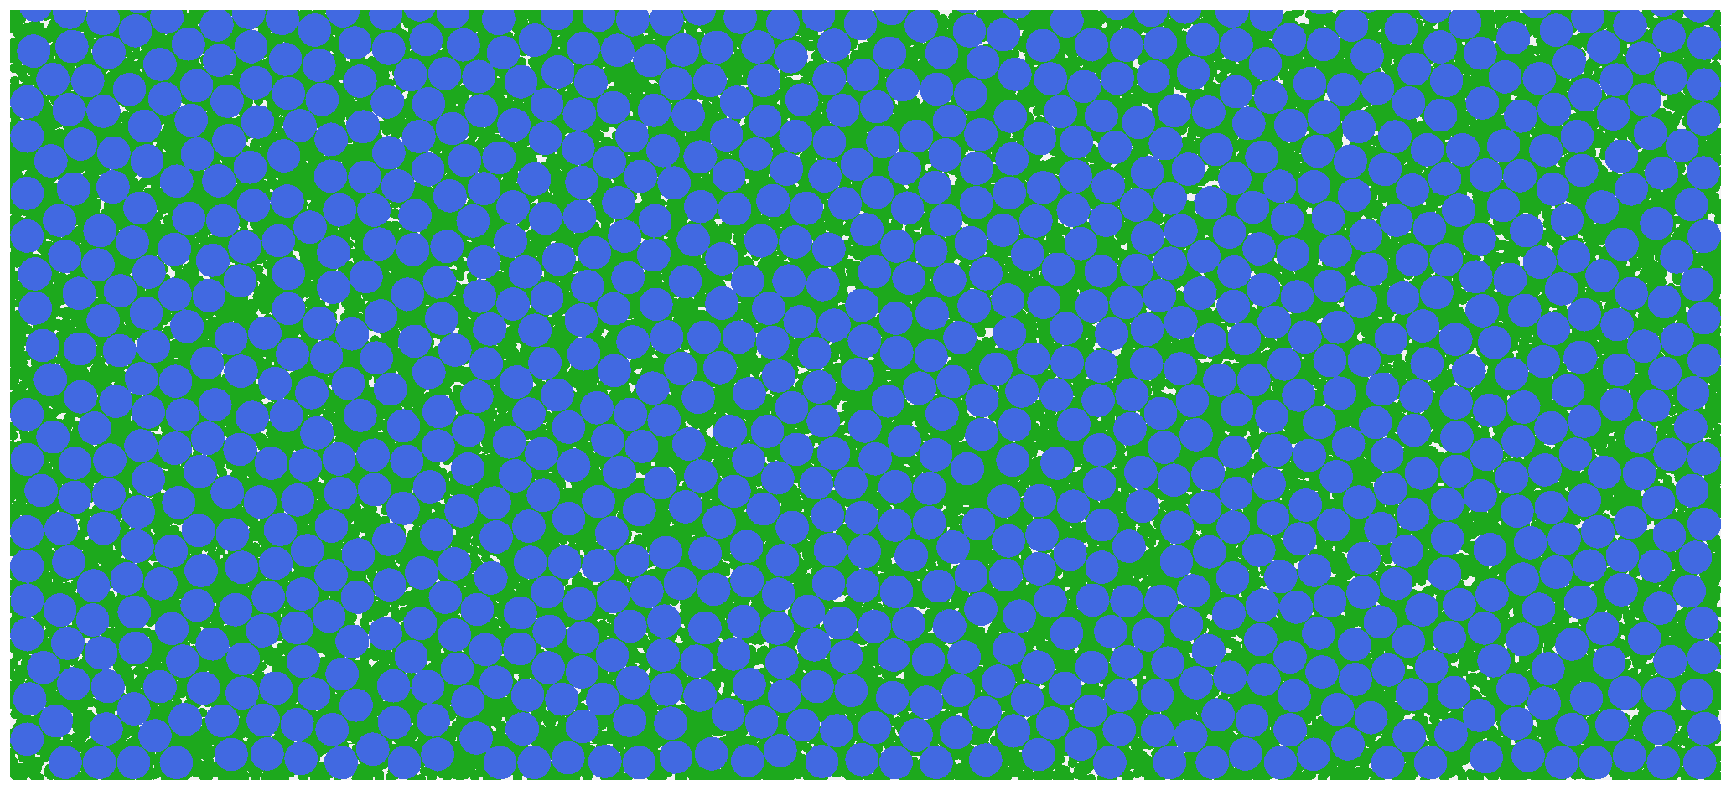

[warn] DXF export skipped: name 'dxf_save_with_frame' is not defined
✔ saved → dem_runs/200x200_4,4,1_0.4,0.4,0.2_NA_20251011-195505/step2_final_fractions.txt
✔ metadata.json updated → snapshots.step2_final


In [14]:
from pathlib import Path
import json, time, math, hashlib
from shapely.ops import unary_union
from shapely.geometry import Polygon, MultiPolygon
from shapely import wkb as _wkb
from PIL import Image, ImageDraw
import numpy as np
import matplotlib.pyplot as plt

STAGE_PLOT_MODE   = "intermediate"  # 'none'|'intermediate'|'all'
ALLOW_SE_REUSE    = False           
SUPER_SAMPLE_VIS  = 32
PIX_PER_UM_VIS    = float(globals().get('PIX_PER_UM', 6.0))  

def _hash_geom(geom):
    try:
        return hashlib.md5(_wkb.dumps(geom, hex=False)).hexdigest()
    except Exception:
        if geom is None or geom.is_empty: return "empty"
        if isinstance(geom, MultiPolygon):
            geoms = list(geom.geoms)
        else:
            geoms = [geom]
        a = sum(g.area for g in geoms)
        bx = tuple(np.round(list(geoms[0].bounds), 6))
        return f"geoms={len(geoms)}|area={a:.6f}|b0={bx}"

def _current_sig():
    return {
        "domain": (float(domain_width), float(domain_height)),
        "target_se_fraction": float(target_se_fraction),
        "se_sizes": tuple([float(s) for s in se_sizes_to_try]),
        "se_cam_overlap_limit": float(se_cam_overlap_limit),
        "se_se_overlap_limit": float(se_se_overlap_limit),
        "strictly_in_void": bool(place_strictly_in_void),
        "cam_hash": _hash_geom(cam_union_step1),
    }

_need_place = True
if ALLOW_SE_REUSE and ('se_geom_final' in globals()) and (se_geom_final is not None):
    prev_sig = globals().get('SE_GEOM_FINAL_SIG', None)
    cur_sig  = _current_sig()
    if isinstance(prev_sig, dict) and prev_sig == cur_sig:
        print("[reuse] se_geom_final signature matched — reuse.")
        _need_place = False
    else:
        print("[info] signature mismatch — re-placement required.")

if _need_place:
    se_geom_final = place_se_in_void(
        cam_geom=cam_union_step1,
        domain=domain_poly,
        target_se_fraction=target_se_fraction,
        se_sizes=se_sizes_to_try,
        se_cam_overlap_limit=se_cam_overlap_limit,
        se_se_overlap_limit=se_se_overlap_limit,
        strictly_in_void=place_strictly_in_void,
        max_attempts_per_particle=9000,
        progress_desc="SE placement (step 2)",
        stage_plot_mode=STAGE_PLOT_MODE,
    )
    SE_GEOM_FINAL_SIG = _current_sig() 

void_final_vec = domain_poly.difference(unary_union([cam_union_step1, se_geom_final]))

def _fmt_num(x, nd=3):
    try:
        xi = float(x)
    except Exception:
        return "NA"
    if abs(xi - round(xi)) < 1e-9:
        return str(int(round(xi)))
    s = f"{xi:.{nd}f}".rstrip("0").rstrip(".")
    return s if s else "0"

def _fmt_csv(*vals):
    return ",".join(_fmt_num(v) for v in vals)

RUNS_DIR = Path("./dem_runs"); RUNS_DIR.mkdir(parents=True, exist_ok=True)
if 'RUN_DIR' in globals() and Path(RUN_DIR).exists():
    OUT_DIR = Path(RUN_DIR)
else:
    if 'DEM_BASE' in globals():
        DW_ = float(DEM_BASE['domain_width']); DH_ = float(DEM_BASE['domain_height'])
        D1v, D2v, D3v = globals().get('D1'), globals().get('D2'), globals().get('D3')
        f1v, f2v, f3v = globals().get('f1'), globals().get('f2'), globals().get('f3')
        SEEDv         = globals().get('SEED')
        base_run_name = f"{_fmt_num(DW_)}x{_fmt_num(DH_)}_{_fmt_csv(D1v,D2v,D3v)}_{_fmt_csv(f1v,f2v,f3v)}_{SEEDv if SEEDv is not None else 'NA'}"
    else:
        base_run_name = f"{_fmt_num(domain_width)}x{_fmt_num(domain_height)}_unknown_{int(time.time())}"
    OUT_DIR = RUNS_DIR / base_run_name
    if OUT_DIR.exists():
        ts = time.strftime("%Y%m%d-%H%M%S")
        OUT_DIR = RUNS_DIR / f"{base_run_name}_{ts}"
    OUT_DIR.mkdir(parents=True, exist_ok=True)

print(f"[save] Output folder = {OUT_DIR.resolve()}")

cam_vec = cam_union_step1.buffer(0)
se_vec  = se_geom_final.buffer(0)

union_cam_se = unary_union([cam_vec, se_vec])
overlap_geom = cam_vec.intersection(se_vec)
cam_only     = cam_vec.difference(se_vec)
se_only      = se_vec.difference(cam_vec)

_total_area      = float(domain_poly.area)
_cam_area_ex     = float(cam_only.area)
_se_area_ex      = float(se_only.area)
_overlap_area    = float(overlap_geom.area)
_union_area      = float(union_cam_se.area)
_void_area_vec   = max(0.0, _total_area - _union_area)

_cam_frac_vec    = _cam_area_ex  / _total_area if _total_area > 0 else 0.0
_se_frac_vec     = _se_area_ex   / _total_area if _total_area > 0 else 0.0
_void_frac_vec   = _void_area_vec/ _total_area if _total_area > 0 else 0.0
_overlap_frac    = _overlap_area / _total_area if _total_area > 0 else 0.0

print("\n===== Final Fractions (vector, exclusive) =====")
print(f" CAM(excl): {_cam_frac_vec:.3%}")
print(f" SE (excl): {_se_frac_vec:.3%} (target: {target_se_fraction:.3%})")
print(f" Overlap  : {_overlap_frac:.3%}  (CAM∩SE, info)")
print(f" Void     : {_void_frac_vec:.3%}")

domain_w_um, domain_h_um = float(domain_width), float(domain_height)
sx = sy = float(PIX_PER_UM_VIS)
Wpx, Hpx = int(round(domain_w_um*sx)), int(round(domain_h_um*sy))
W2, H2   = Wpx*SUPER_SAMPLE_VIS, Hpx*SUPER_SAMPLE_VIS
sx2, sy2 = sx*SUPER_SAMPLE_VIS, sy*SUPER_SAMPLE_VIS

def _poly_to_pixel_rings(poly: Polygon, sx: float, sy: float, W: int, H: int, H_um: float):
    def _ring_to_pts(ring):
        xs, ys = np.asarray(ring.coords.xy[0]), np.asarray(ring.coords.xy[1])
        xpix = xs * sx - 0.5
        ypix = (H_um - ys) * sy - 0.5
        xpix = np.clip(xpix, 0.0, W - 1.0)
        ypix = np.clip(ypix, 0.0, H - 1.0)
        return list(map(tuple, np.stack([xpix, ypix], axis=1)))
    ext = _ring_to_pts(poly.exterior)
    holes = [_ring_to_pts(r) for r in poly.interiors]
    return ext, holes

def _draw_mask_hi(geom):
    if geom is None or getattr(geom, "is_empty", True):
        return np.zeros((H2, W2), dtype=np.uint8)
    hi = Image.new('1', (W2, H2), 0); draw = ImageDraw.Draw(hi)
    geoms = list(geom.geoms) if isinstance(geom, MultiPolygon) else [geom]
    for g in geoms:
        ext, holes = _poly_to_pixel_rings(g, sx2, sy2, W2, H2, domain_h_um)
        if len(ext) >= 3: draw.polygon(ext, outline=None, fill=1)
        for h in holes:
            if len(h) >= 3: draw.polygon(h, outline=None, fill=0)
    return np.array(hi, dtype=np.uint8)

from skimage.measure import block_reduce
cam_hi = _draw_mask_hi(cam_vec)
se_hi  = _draw_mask_hi(se_vec)
cam_cnt = block_reduce(cam_hi, block_size=(SUPER_SAMPLE_VIS, SUPER_SAMPLE_VIS), func=np.sum)
se_cnt  = block_reduce(se_hi,  block_size=(SUPER_SAMPLE_VIS, SUPER_SAMPLE_VIS), func=np.sum)

se_m   = (se_cnt > cam_cnt) | ((se_cnt == cam_cnt) & (se_cnt > 0))
cam_m  = (cam_cnt > se_cnt)
void_m = ~(cam_m | se_m)

assert not (cam_m & se_m).any(), "CAM∩SE overlap exists (raster, impossible)"
cover = cam_m | se_m | void_m
assert cover.all(), f"unlabeled pixels: {cover.size - cover.sum()}"

label = np.zeros((Hpx, Wpx), dtype=np.uint8)
label[void_m] = 3; label[se_m] = 2; label[cam_m] = 1
img = np.zeros((Hpx, Wpx, 3), dtype=np.uint8)
img[label==3]=(242,242,242); img[label==2]=(29,169,29); img[label==1]=(65,105,225)

png_path = OUT_DIR / "step2_snapshot.png"
Image.fromarray(img).save(png_path)
print(f" saved → {png_path}")

tot = label.size
cam_frac_r = (label==1).sum()/tot
se_frac_r  = (label==2).sum()/tot
void_frac_r= (label==3).sum()/tot
print("[raster check] CAM=%.3f%%  SE=%.3f%%  VOID=%.3f%%  sum=100.000%%" %
      (100.0*cam_frac_r, 100.0*se_frac_r, 100.0*void_frac_r))

plt.figure(figsize=(8*domain_w_um/domain_h_um, 8))
plt.imshow(img, interpolation='nearest')
plt.axis('off'); plt.tight_layout(); plt.show()

try:
    dxf_final_micro_filename = OUT_DIR / "step2_cam_se_final.dxf"
    dxf_save_with_frame(str(dxf_final_micro_filename),
                        cam_geom=cam_vec, se_geom=se_vec,
                        frame_w=float(domain_width), frame_h=float(domain_height))
    print(f"saved → {dxf_final_micro_filename}")
except Exception as e:
    print(f"[warn] DXF export skipped: {e}")
    dxf_final_micro_filename = None

txt_path = OUT_DIR / "step2_final_fractions.txt"
with open(txt_path, "w", encoding="utf-8") as f:
    f.write("===== Final Fractions (Step 2) =====\n")
    f.write(f"Domain area         : {_total_area:.6f} µm²\n")
    f.write(f"CAM area (exclusive): {_cam_area_ex:.6f} µm² ({_cam_frac_vec*100:.3f}%)\n")
    f.write(f"SE  area (exclusive): {_se_area_ex:.6f} µm² ({_se_frac_vec*100:.3f}%)\n")
    f.write(f"CAM∩SE overlap      : {_overlap_area:.6f} µm² ({_overlap_frac*100:.3f}%)\n")
    f.write(f"Void area (vector)  : {_void_area_vec:.6f} µm² ({_void_frac_vec*100:.3f}%)\n")
    f.write(f"(target SE fraction, domain) : {target_se_fraction:.6f} ({target_se_fraction*100:.3f}%)\n")
    if dxf_final_micro_filename:
        f.write(f"DXF file : {dxf_final_micro_filename.name}\n")
print(f" saved → {txt_path}")

meta_path = OUT_DIR / "metadata.json"
try:
    meta = json.loads(meta_path.read_text(encoding="utf-8")) if meta_path.exists() else {}
except Exception:
    meta = {}
meta.setdefault("snapshots", {})
meta["snapshots"]["step2_final"] = {
    "domain_width_um": float(domain_width),
    "domain_height_um": float(domain_height),
    "areas_um2": {
        "domain": _total_area,
        "cam_exclusive": _cam_area_ex,
        "se_exclusive": _se_area_ex,
        "overlap_cam_se": _overlap_area,
        "void_vector": _void_area_vec,
    },
    "fractions_domain_vector": {
        "cam_exclusive": _cam_frac_vec,
        "se_exclusive": _se_frac_vec,
        "overlap_cam_se": _overlap_frac,
        "void": _void_frac_vec,
        "target_se": float(target_se_fraction),
    },
    "fractions_domain_raster": {
        "cam": float(cam_frac_r),
        "se": float(se_frac_r),
        "void": float(void_frac_r),
    },
    "files": {
        "snapshot_png": str(png_path.name),
        "final_dxf": (str(dxf_final_micro_filename.name) if dxf_final_micro_filename else None),
        "final_txt": str(txt_path.name),
    },
}
meta_path.write_text(json.dumps(meta, ensure_ascii=False, indent=2), encoding="utf-8")
print(f" metadata.json updated → snapshots.step2_final")

In [15]:
import json, math, warnings
import numpy as np
from pathlib import Path
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
from shapely.geometry import Polygon, MultiPolygon
from skimage.measure import block_reduce
import porespy as ps

assert 'cam_union_step1' in globals() and 'se_geom_final' in globals(), \
    "cam_union_step1 / se_geom_final should exist in memory."

RUNS_DIR = Path("./dem_runs"); RUNS_DIR.mkdir(parents=True, exist_ok=True)
if 'OUT_DIR' in globals() and Path(OUT_DIR).exists():
    OUT_DIR = Path(OUT_DIR)
else:
    OUT_DIR = RUNS_DIR 

meta_path = OUT_DIR / "metadata.json"

PIX_PER_UM   = 32.0          
SUPER_SAMPLE = 32           

domain_w_um = float(domain_width)
domain_h_um = float(domain_height)
sx = sy = float(PIX_PER_UM)
width_px  = int(round(domain_w_um * sx))
height_px = int(round(domain_h_um * sy))

max_mpx = 120.0
hi_mpx  = (width_px*height_px*SUPER_SAMPLE*SUPER_SAMPLE)/1e6
if hi_mpx > max_mpx:
    SUPER_SAMPLE = max(8, int(math.floor(math.sqrt(max_mpx*1e6/(width_px*height_px)))))

def _poly_to_pixel_rings(poly: Polygon, sx: float, sy: float, W: int, H: int):
    def _ring_to_pts(ring):
        xs = np.asarray(ring.coords.xy[0]); ys = np.asarray(ring.coords.xy[1])
        xpix = xs * sx - 0.5
        ypix = (domain_h_um - ys) * sy - 0.5
        xpix = np.clip(xpix, 0.0, W - 1.0)
        ypix = np.clip(ypix, 0.0, H - 1.0)
        return list(map(tuple, np.stack([xpix, ypix], axis=1)))
    ext = _ring_to_pts(poly.exterior)
    holes = [_ring_to_pts(r) for r in poly.interiors]
    return ext, holes

def _draw_mask_hi(geom, W2, H2, sx2, sy2):
    if geom is None or getattr(geom, "is_empty", True):
        return np.zeros((H2, W2), dtype=np.uint8)
    hi = Image.new('1', (W2, H2), 0)
    draw = ImageDraw.Draw(hi)
    geoms = list(geom.geoms) if isinstance(geom, MultiPolygon) else [geom]
    for g in geoms:
        ext, holes = _poly_to_pixel_rings(g, sx2, sy2, W2, H2)
        if len(ext) >= 3:
            draw.polygon(ext, outline=None, fill=1)
        for h in holes:
            if len(h) >= 3:
                draw.polygon(h, outline=None, fill=0)
    return np.array(hi, dtype=np.uint8)

W2, H2 = width_px*SUPER_SAMPLE, height_px*SUPER_SAMPLE
sx2, sy2 = sx*SUPER_SAMPLE, sy*SUPER_SAMPLE

cam_vec = cam_union_step1.buffer(0)
se_vec  = se_geom_final.buffer(0)

cam_hi = _draw_mask_hi(cam_vec, W2, H2, sx2, sy2)
se_hi  = _draw_mask_hi(se_vec,  W2, H2, sx2, sy2)

cam_cnt = block_reduce(cam_hi, block_size=(SUPER_SAMPLE, SUPER_SAMPLE), func=np.sum)
se_cnt  = block_reduce(se_hi,  block_size=(SUPER_SAMPLE, SUPER_SAMPLE), func=np.sum)

se_mask_bool  = (se_cnt >= cam_cnt) & (se_cnt > 0)
cam_mask_bool = (cam_cnt > se_cnt)
void_mask_bool = ~(cam_mask_bool | se_mask_bool)

assert not (cam_mask_bool & se_mask_bool).any()
assert (cam_mask_bool | se_mask_bool | void_mask_bool).all()

phase_rgb = np.zeros((height_px, width_px, 3), dtype=np.uint8)
phase_rgb[cam_mask_bool]  = (0, 200, 0)      # CAM (non-conducting)
phase_rgb[se_mask_bool]   = (128, 128, 128)  # SE  (conducting)
phase_rgb[void_mask_bool] = (255, 0, 0)      # VOID (non-conducting)
phase_map_path = OUT_DIR / "phase_map_SE_conducting.png"
Image.fromarray(phase_rgb).save(phase_map_path)
print(f" saved → {phase_map_path}")

CONTACT_GUARD = True
PAD_UM = 0.5
if CONTACT_GUARD:
    PAD = max(1, int(round(PAD_UM * sy)))
    def _ensure_contact(mask: np.ndarray, pad: int = 1):
        m = mask.copy(); H, W = m.shape
        if H > 1 and not m[0, :].any():      m[0, :]  = np.any(m[1:min(1+pad, H), :], axis=0)
        if H > 1 and not m[-1, :].any():     m[-1, :] = np.any(m[max(0, H-1-pad):H-1, :], axis=0)
        if W > 1 and not m[:, 0].any():      m[:, 0]  = np.any(m[:, 1:min(1+pad, W)], axis=1)
        if W > 1 and not m[:, -1].any():     m[:, -1] = np.any(m[:, max(0, W-1-pad):W-1], axis=1)
        return m
    se_mask_bool = _ensure_contact(se_mask_bool, pad=PAD)

binary_mask = se_mask_bool.astype(bool)

try:
    from skimage.measure import label as _lbl
    def percolates(mask: np.ndarray, axis: int) -> bool:
        if not mask.any(): return False
        L = _lbl(mask, connectivity=1)
        if axis == 0:
            a = set(L[0, :].ravel()) - {0}; b = set(L[-1, :].ravel()) - {0}
        else:
            a = set(L[:, 0].ravel()) - {0};  b = set(L[:, -1].ravel()) - {0}
        return len(a & b) > 0
except Exception:
    def percolates(mask: np.ndarray, axis: int) -> bool:
        return bool(mask[0, :].any() and mask[-1, :].any()) if axis == 0 else bool(mask[:, 0].any() and mask[:, -1].any())

def _solve_tau(mask: np.ndarray, axis: int):
    if not percolates(mask, axis):
        return None, "no-percolation"
    H, W = mask.shape
    inl = np.zeros_like(mask, bool); out = np.zeros_like(mask, bool)
    if axis == 0:
        inl[0, :], out[-1, :] = mask[0, :], mask[-1, :]
    else:
        inl[:, 0], out[:, -1] = mask[:, 0], mask[:, -1]
    try:
        try:
            import pyamg  # noqa
            res = ps.simulations.tortuosity_fd(mask, axis=axis, inlets=inl, outlets=out, solver='pyamg')
            return res, "pyamg"
        except Exception:
            res = ps.simulations.tortuosity_fd(mask, axis=axis, inlets=inl, outlets=out, solver='scipy')
            return res, "scipy"
    except TypeError:
        try:
            res = ps.simulations.tortuosity_fd(mask, axis=axis)
            return res, "compat"
        except Exception as e:
            warnings.warn(f"tortuosity_fd(compat) failed axis={axis}: {e}")
            return None, f"error:{type(e).__name__}"
    except Exception as e:
        warnings.warn(f"tortuosity_fd failed axis={axis}: {e}")
        return None, f"error:{type(e).__name__}"

res_y, solver_y = _solve_tau(binary_mask, axis=0)
res_x, solver_x = _solve_tau(binary_mask, axis=1)

def _fv(v): 
    try: return float(v)
    except: return float('nan')

phi_eff_candidates = []
if res_y is not None and hasattr(res_y, "effective_porosity"): phi_eff_candidates.append(_fv(res_y.effective_porosity))
if res_x is not None and hasattr(res_x, "effective_porosity"): phi_eff_candidates.append(_fv(res_x.effective_porosity))
phi_eff = next((v for v in phi_eff_candidates if np.isfinite(v)), float(np.mean(binary_mask)))

tau_y   = _fv(getattr(res_y, "tortuosity", np.nan))
tau_x   = _fv(getattr(res_x, "tortuosity", np.nan))
F_y     = _fv(getattr(res_y, "formation_factor", np.nan))
F_x     = _fv(getattr(res_x, "formation_factor", np.nan))
D_eff_y = (1.0/F_y) if (np.isfinite(F_y) and F_y!=0) else np.nan
D_eff_x = (1.0/F_x) if (np.isfinite(F_x) and F_x!=0) else np.nan

print("===== Tortuosity (SE conducting) =====")
print(f"phi_eff  : {phi_eff:.6f}")
print(f"tau_y    : {tau_y:.6f} | D_eff_y={D_eff_y:.6f} | F_y={F_y:.6f} [{solver_y}]")
print(f"tau_x    : {tau_x:.6f} | D_eff_x={D_eff_x:.6f} | F_x={F_x:.6f} [{solver_x}]")

NN = dict(interpolation='nearest')
conc_y = getattr(res_y, "concentration", None) if res_y is not None else None
conc_x = getattr(res_x, "concentration", None) if res_x is not None else None

def _masked(c, m): 
    return None if c is None else np.ma.masked_where(~m, c)

plt.figure(figsize=(14, 10))
plt.subplot(2,2,1); plt.imshow(phase_rgb, **NN); plt.title('Phase (CAM=green, SE=gray, VOID=red)'); plt.axis('off')
plt.subplot(2,2,2); plt.imshow(binary_mask, cmap='gray', **NN); plt.title(f'SE mask (phi={phi_eff:.3f})'); plt.axis('off')
plt.subplot(2,2,3)
mc = _masked(conc_y, binary_mask)
if mc is not None: plt.imshow(mc, cmap='viridis', **NN); plt.colorbar(label='Concentration')
else:             plt.text(0.5,0.5,'no percolation / no field',ha='center',va='center')
plt.title(f'Axis=0 (tau_y={tau_y:.3f})'); plt.axis('off')
plt.subplot(2,2,4)
mc = _masked(conc_x, binary_mask)
if mc is not None: plt.imshow(mc, cmap='viridis', **NN); plt.colorbar(label='Concentration')
else:             plt.text(0.5,0.5,'no percolation / no field',ha='center',va='center')
plt.title(f'Axis=1 (tau_x={tau_x:.3f})'); plt.axis('off')
plt.tight_layout()
viz_path = OUT_DIR / 'tortuosity_SE_conducting.png'
plt.savefig(viz_path, dpi=300, bbox_inches='tight'); plt.close()
print(f" saved → {viz_path}")

res_txt = OUT_DIR / 'tortuosity_results_SE_conducting.txt'
with open(res_txt, 'w', encoding='utf-8') as f:
    f.write('Tortuosity (SE = ion-conducting)\n')
    f.write('================================\n')
    f.write(f'Domain (µm): W={domain_w_um}, H={domain_h_um}\n')
    f.write(f'Raster size : {width_px} x {height_px} px  (sx={sx:.3f}, sy={sy:.3f} px/µm)\n')
    f.write(f'phi_eff     : {phi_eff:.6f}\n')
    f.write(f'tau_x       : {tau_x:.6f}\n')
    f.write(f'tau_y       : {tau_y:.6f}\n')
    f.write(f'D_eff_x     : {D_eff_x:.6f}\n')
    f.write(f'D_eff_y     : {D_eff_y:.6f}\n')
    f.write(f'F_x         : {F_x:.6f}\n')
    f.write(f'F_y         : {F_y:.6f}\n')
    f.write(f'solver_x    : {solver_x}\n')
    f.write(f'solver_y    : {solver_y}\n')
print(f" saved → {res_txt}")

try:
    meta = json.loads(meta_path.read_text(encoding="utf-8")) if meta_path.exists() else {}
except Exception:
    meta = {}
meta.setdefault("tortuosity", {})
meta["tortuosity"]["se_conducting"] = {
    "domain_um": {"W": domain_w_um, "H": domain_h_um},
    "raster": {"width_px": int(width_px), "height_px": int(height_px),
               "sx": float(sx), "sy": float(sy), "super_sample": int(SUPER_SAMPLE)},
    "results": {
        "phi_eff": float(phi_eff),
        "tau_x": None if not np.isfinite(tau_x) else float(tau_x),
        "tau_y": None if not np.isfinite(tau_y) else float(tau_y),
        "D_eff_x": None if not np.isfinite(D_eff_x) else float(D_eff_x),
        "D_eff_y": None if not np.isfinite(D_eff_y) else float(D_eff_y),
        "F_x": None if not np.isfinite(F_x) else float(F_x),
        "F_y": None if not np.isfinite(F_y) else float(F_y),
        "solver": {"x": solver_x, "y": solver_y}
    },
    "files": {
        "phase_map": Path(phase_map_path).name,
        "viz": 'tortuosity_SE_conducting.png',
        "text": Path(res_txt).name
    }
}
meta_path.write_text(json.dumps(meta, ensure_ascii=False, indent=2), encoding="utf-8")
print(f" metadata.json updated → tortuosity.se_conducting")

✔ saved → dem_runs/200x200_4,4,1_0.4,0.4,0.2_NA_20251011-195505/phase_map_SE_conducting.png


[20:55:07] WARNING  Found non-percolating regions, were filled to percolate                              ]8;id=823351;file:///home/nam/anaconda3/envs/sam_env/lib/python3.10/site-packages/porespy/simulations/_dns.py\_dns.py]8;;\:]8;id=992798;file:///home/nam/anaconda3/envs/sam_env/lib/python3.10/site-packages/porespy/simulations/_dns.py#74\74]8;;\

[20:56:36] ERROR    Inlet/outlet rates don't match: 1.2202e-01 vs. -1.2151e-01                          ]8;id=770990;file:///home/nam/anaconda3/envs/sam_env/lib/python3.10/site-packages/porespy/simulations/_dns.py\_dns.py]8;;\:]8;id=565346;file:///home/nam/anaconda3/envs/sam_env/lib/python3.10/site-packages/porespy/simulations/_dns.py#107\107]8;;\

           WARNING  Found non-percolating regions, were filled to percolate                              ]8;id=425641;file:///home/nam/anaconda3/envs/sam_env/lib/python3.10/site-packages/porespy/simulations/_dns.py\_dns.py]8;;\:]8;id=848312;file:///home/nam/anaconda3/envs/sam_env/lib/python3.10/site-packages/porespy/simulations/_dns.py#74\74]8;;\

[21:01:49] ERROR    Inlet/outlet rates don't match: 1.8920e-02 vs. -1.8275e-02                          ]8;id=1103;file:///home/nam/anaconda3/envs/sam_env/lib/python3.10/site-packages/porespy/simulations/_dns.py\_dns.py]8;;\:]8;id=746941;file:///home/nam/anaconda3/envs/sam_env/lib/python3.10/site-packages/porespy/simulations/_dns.py#107\107]8;;\

===== Tortuosity (SE conducting) =====
phi_eff  : 0.310421
tau_y    : 5.655370 | D_eff_y=0.054890 | F_y=18.218407 [compat]
tau_x    : 7.384292 | D_eff_x=0.042038 | F_x=23.788015 [compat]


✔ saved → dem_runs/200x200_4,4,1_0.4,0.4,0.2_NA_20251011-195505/tortuosity_SE_conducting.png
✔ saved → dem_runs/200x200_4,4,1_0.4,0.4,0.2_NA_20251011-195505/tortuosity_results_SE_conducting.txt
✔ metadata.json updated → tortuosity.se_conducting


In [16]:
# ===== Batch runner (Papermill) — save under /mnt/c (original folder), lean logs =====
if globals().get("_PM_CHILD_RUN", False):
    print("[batch] Child execution detected → skipping batch runner cell.")
else:
    from pathlib import Path
    import papermill as pm
    import json, time, os, re, threading, traceback
    from tqdm.auto import tqdm

    try:
        import ipynbname
        NB_PATH = Path(ipynbname.path())
    except Exception:
        NB_PATH = Path("CODE(.ipynb)PATH")

    NB_PATH = NB_PATH.resolve()
    print(f"[Batch] Using notebook: {NB_PATH}")
    if not NB_PATH.exists():
        raise FileNotFoundError(f"no file exist: {NB_PATH}")

    BASE_DIR = NB_PATH.parent

    FALLBACK_MNT = Path("CODE PATH")
    if not str(BASE_DIR).startswith("/mnt/") and FALLBACK_MNT.exists():
        print(f"[warn] BASE_DIR={BASE_DIR} (not under /mnt). Forcing to {FALLBACK_MNT}")
        BASE_DIR = FALLBACK_MNT

    OUT_NB_DIR  = BASE_DIR / "batch_outputs"   
    DEM_BASE_DIR = BASE_DIR / "dem_runs"       
    OUT_NB_DIR.mkdir(parents=True, exist_ok=True)
    DEM_BASE_DIR.mkdir(parents=True, exist_ok=True)

    print("[save executed notebooks to]", OUT_NB_DIR.resolve())
    print("[ensure DEM base dir]", DEM_BASE_DIR.resolve())
    print("[cwd for child runs] ", BASE_DIR.resolve())

    # Parameter sets
    param_sets = [
        dict(D1=4.0,  D2=4.0,  D3=1.0, f1=0.4,  f2=0.4,  f3=0.2)
    ]

    def extract_cell_titles(nb_path: Path):
        try:
            nb = json.loads(nb_path.read_text(encoding="utf-8"))
            titles, idx = [], 0
            pat = re.compile(r"^#\s*={2,}\s*Cell\s*(\d+)\s*[—-]\s*(.*?)\s*={2,}\s*$")
            for cell in nb.get("cells", []):
                if cell.get("cell_type") != "code":
                    continue
                idx += 1
                src = "".join(cell.get("source", []))
                first = src.splitlines()[0].strip() if src else ""
                m = pat.match(first)
                if m:
                    titles.append(f"Cell {m.group(1)} — {m.group(2)}")
                else:
                    title = None
                    for ln in src.splitlines():
                        s = ln.strip()
                        if s.startswith("#"):
                            title = s.lstrip("#").strip()
                            break
                    titles.append(title or f"Cell {idx}")
            return titles
        except Exception:
            return []

    SOURCE_TITLES = extract_cell_titles(NB_PATH)

    MONITOR_INTERVAL = 5.0  
    def monitor_notebook(out_nb_path: Path, stop_event: threading.Event, tag: str):
        last_done, total = -1, None
        try:
            while not stop_event.is_set():
                try:
                    if out_nb_path.exists():
                        nb = json.loads(out_nb_path.read_text(encoding="utf-8", errors="ignore"))
                        cells = [c for c in nb.get("cells", []) if c.get("cell_type") == "code"]
                        total = len(cells) if cells else total
                        done = 0
                        for c in cells:
                            if c.get("execution_count"):
                                done += 1
                            else:
                                break
                        if total is not None and done != last_done:
                            title = SOURCE_TITLES[done-1] if (done-1) < len(SOURCE_TITLES) and done > 0 else f"Cell {done}"
                            print(time.strftime("[%H:%M:%S]"), f"[{tag}] {done}/{total} → {title}", flush=True)
                            last_done = done
                except Exception:
                    pass
                time.sleep(MONITOR_INTERVAL)
        finally:
            pass

    def _fmt(x):
        s = f"{float(x):.6g}".rstrip("0").rstrip(".")
        return s if s else "0"

    def _tag(p):
        return f"D={_fmt(p['D1'])}-{_fmt(p['D2'])}-{_fmt(p['D3'])}_f={_fmt(p['f1'])}-{_fmt(p['f2'])}-{_fmt(p['f3'])}"

    ok_runs, fail_runs = [], []

    for i, p in enumerate(param_sets, 1):
        tag = _tag(p)
        out_nb = OUT_NB_DIR / f"run{i}_{tag}.ipynb"
        print(f"\n=== [{i}/{len(param_sets)}] {tag} ===")
        print(f"[save] {out_nb}")

        if not out_nb.exists():
            out_nb.write_text('{"cells": [], "metadata": {}, "nbformat": 4, "nbformat_minor": 5}', encoding="utf-8")
            try:
                os.sync()
            except Exception:
                pass

        stop_evt = threading.Event()
        mon_thr = threading.Thread(target=monitor_notebook, args=(out_nb, stop_evt, tag), daemon=True)
        mon_thr.start()

        t0 = time.time()
        try:
            injected = dict(
                _PM_CHILD_RUN=True,
                _BATCH_TQDM_MININTERVAL=5.0,
                _BATCH_TQDM_MINPCT=1.0,
            )
            injected.update(p)

            pm.execute_notebook(
                input_path=str(NB_PATH),
                output_path=str(out_nb),
                parameters=injected,
                progress_bar=True,
                request_save_on_cell_execute=True,
                log_output=True,
                cwd=str(BASE_DIR),   
            )
            print(f"[OK] {tag}  ({time.time()-t0:.1f}s)")
            ok_runs.append(out_nb)
        except Exception as e:
            print(f"[FAIL] {tag}: {type(e).__name__}: {e}")
            traceback.print_exc()
            fail_runs.append((p, e))
        finally:
            stop_evt.set()
            mon_thr.join(timeout=5)

    print("\n--- Batch summary ---")
    print("OK   :", len(ok_runs))
    for nb in ok_runs: print("  -", nb)
    print("FAIL :", len(fail_runs))
    for ps, e in fail_runs: print("  -", ps, "→", repr(e))

    print("\n each run results (DEM_BASE_DIR / "<auto-named-folder>").parent, "saved here.")

[batch] Child execution detected → skipping batch runner cell.
